<h1 style="text-align:center;font-size:40px;" >Google Analytics Customer Revenue Prediction </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

RStudio, the developer of free and open tools for R and enterprise-ready products for teams to scale and share work, has partnered with Google Cloud and Kaggle to demonstrate the business impact that thorough data analysis can have.

In this competition, you’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data. </p>
<br>
> Credits: Kaggle

__ Problem Statement __ <br>

The Google merchandise store wants to know which customers are generating the most revenue (customer value). Understanding customer value will allow the business to strategically dedicate resources to maximize their return on investment <br>

- goal: Predict the revenue of a customer


<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/ga-customer-revenue-prediction
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/c/ga-customer-revenue-prediction
- Kaggle Winning Solution and other approaches: 
- Blog 1 : https://sureoptimize.com/marketing-analytics-data-science
- Blog 2 : https://medium.com/@jacky308082/this-time-i-would-try-to-use-english-to-explain-this-whole-project-4a26c9294ccf

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train_v2.csv <br>
- Train.csv contains 13 columns <br>
- Size of Train.csv - 23.64 GB <br>
- Number of rows in Train_v2.csv=1708337
</p>

<h3> 2.1.2 Example Data point </h3>

- fullVisitorId- A unique identifier for each user of the Google Merchandise Store.<br>
- channelGrouping - The channel via which the user came to the Store.<br>
- date - The date on which the user visited the Store.<br>
- device - The specifications for the device used to access the Store.<br>
- geoNetwork - This section contains information about the geography of the user.<br>
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".<br>
- totals - This section contains aggregate values across the session.<br>
- trafficSource - This section contains information about the Traffic Source from which the session -originated.<br>
- visitId - An identifier for this session. This is part of the value usually stored as the _utmb ---cookie. This is only unique to the user. For a completely unique ID, you should use a combination of -fullVisitorId and visitId.<br>
- visitNumber - The session number for this user. If this is the first session, then this is set to 1.<br>
- visitStartTime - The timestamp (expressed as POSIX time).<br>
hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.<br>
- customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. <br>
- totals - This set of columns mostly includes high-level aggregate data.

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

It is a regression  problem .

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/ga-customer-revenue-prediction/overview/evaluation


Metric(s): 
* RMSE : https://www.statisticshowto.datasciencecentral.com/rmse/


<h2> 2.3 Train and Test Construction </h2>

We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

<h1>3. Exploratory Data Analysis </h1>

In [254]:
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

#import missingno as msno

%matplotlib inline
plt.style.use('ggplot')
from datetime import datetime, timedelta
from sklearn import model_selection, preprocessing, metrics

<h2> 3.1 Reading data </h2>

In [33]:
#https://github.com/abdkumar/Google-Analytics-Customer-Revenue-Prediction/blob/master/customer%20revenue%20prediction.ipynb
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None

gc.enable()
#define columns which we want to use 
features = ['channelGrouping', 'date', 'fullVisitorId', 'visitId',\
       'visitNumber', 'visitStartTime', 'device.browser',\
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',\
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',\
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',\
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',\
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',\
       'trafficSource.adContent', 'trafficSource.campaign',\
       'trafficSource.isTrueDirect', 'trafficSource.keyword',\
       'trafficSource.medium', 'trafficSource.referralPath',\
       'trafficSource.source']
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']#define the json columns
    ans = pd.DataFrame()#create new data frame
    #read the csv file and load the json olumns and change the fullvisiterid into string ans use chunk for load dataset
    dfs = pd.read_csv(csv_path, sep=',',
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                    chunksize = 50000)
    for df in dfs:#loop for dfs
        df.reset_index(drop = True,inplace = True)
        for column in JSON_COLUMNS:#loop for json columns
            column_as_df = json_normalize(df[column])#Let’s unpack the works column into a standalone dataframe using json_normaliz.
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]#give the column name 
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)#drop the other columns 
        print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
        use_df = df[features]#fetch the only feature columns and other are remove 
        del df#delet df dataframe 
        gc.collect()## Returns the number of objects it has collected and deallocated 
        ans = pd.concat([ans, use_df], axis = 0).reset_index(drop = True)#concat the both dataframe
        print(ans.shape)
    return ans

In [0]:
#new_df["trafficSource.campaignCode"].notnull().sum()

In [35]:
%%time
#path="E:\\data science case studys\\"
#train_df = load_df(path+"train_v2.csv")

#test_df = load_df(path+"test_v2.csv")

Wall time: 0 ns


In [36]:
%%time
train_df = load_df(path+"train_v2.csv")

Loaded train_v2.csv. Shape: (50000, 59)
(50000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(100000, 29)
Loaded train_v2.csv. Shape: (50000, 60)
(150000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(200000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(250000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(300000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(350000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(400000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(450000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(500000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(550000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(600000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(650000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(700000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(750000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(800000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(850000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(900000, 29)
Loaded train_v2.csv. Shape: (50000, 59)
(950000

In [37]:
%%time
test_df = load_df(path+"test_v2.csv")

Loaded test_v2.csv. Shape: (50000, 59)
(50000, 29)
Loaded test_v2.csv. Shape: (50000, 59)
(100000, 29)
Loaded test_v2.csv. Shape: (50000, 59)
(150000, 29)
Loaded test_v2.csv. Shape: (50000, 59)
(200000, 29)
Loaded test_v2.csv. Shape: (50000, 59)
(250000, 29)
Loaded test_v2.csv. Shape: (50000, 59)
(300000, 29)
Loaded test_v2.csv. Shape: (50000, 59)
(350000, 29)
Loaded test_v2.csv. Shape: (50000, 59)
(400000, 29)
Loaded test_v2.csv. Shape: (1589, 59)
(401589, 29)
Wall time: 7min 35s


In [38]:
temp_train=train_df
temp_test=test_df

In [39]:
temp_train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,1,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,2,NaN,2,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,NaN,2,1,2,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,NaN,2,1,2,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,NaN,2,1,2,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [40]:
temp_train.info()#print info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 29 columns):
channelGrouping               object
date                          int64
fullVisitorId                 object
visitId                       int64
visitNumber                   int64
visitStartTime                int64
device.browser                object
device.deviceCategory         object
device.isMobile               bool
device.operatingSystem        object
geoNetwork.city               object
geoNetwork.continent          object
geoNetwork.country            object
geoNetwork.metro              object
geoNetwork.networkDomain      object
geoNetwork.region             object
geoNetwork.subContinent       object
totals.bounces                object
totals.hits                   object
totals.newVisits              object
totals.pageviews              object
totals.transactionRevenue     object
trafficSource.adContent       object
trafficSource.campaign        object
traff

In [41]:
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print("Total columns at least one Values: ")
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0    
    print("\n Total of Sales % of Total: ", round((data[data['totals.transactionRevenue'] != np.nan]
                     ['totals.transactionRevenue'].count()/ len(data['totals.transactionRevenue']) * 100),4))    
    return

In [42]:
missing_values(temp_train)

Total columns at least one Values: 
                              Total    Percent
totals.transactionRevenue   1689823  98.916256
trafficSource.adContent     1643600  96.210525
trafficSource.isTrueDirect  1173819  68.711209
trafficSource.referralPath  1142073  66.852910
trafficSource.keyword       1052780  61.626014
totals.bounces               836759  48.980910
totals.newVisits             400907  23.467676
totals.pageviews                239   0.013990

 Total of Sales % of Total:  1.0837


<h3> 3.2.1 Distribution of data points among output classes</h3>
- totals.transactionRevenue

In [43]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')#change the columns into float
dis=train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

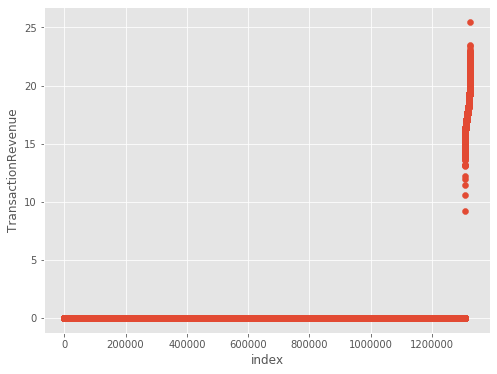

In [44]:
plt.figure(figsize=(8,6))
plt.scatter(range(dis.shape[0]), np.sort(np.log1p(dis["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

here we can see that 20% of customers are responsible for 80% or total transaction

<h3> 3.2.2 how much revenue generating from customers</h3>

In [45]:
Non_reven=dis[dis["totals.transactionRevenue"]==0]
reven=dis[dis["totals.transactionRevenue"]>0]
print("The number of nonrevenue customers are ", len(Non_reven))
print("The number of revenue generating customers are ", len(reven))
print("the ratio of revenue generating customers are {0:0.4}%".format(len(reven)/len(dis)*100))

The number of nonrevenue customers are  1307589
The number of revenue generating customers are  16141
the ratio of revenue generating customers are 1.219%


In [46]:
train_df['totals.transactionRevenue'].fillna(0.0, inplace=True)

### If we only consider non zero transactionRevenue


In [47]:
non_zero = train_df[train_df['totals.transactionRevenue']>0] ['totals.transactionRevenue']

In [48]:
non_zero.describe()

count    1.851400e+04
mean     1.251132e+08
std      4.162653e+08
min      1.000000e+04
25%      2.306750e+07
50%      4.606000e+07
75%      1.000000e+08
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

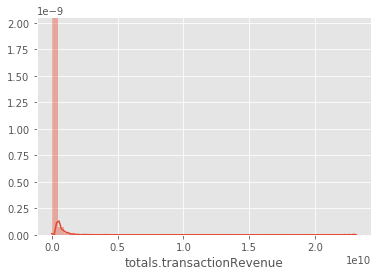

In [49]:
sns.distplot(non_zero)

distribution is not normal and also submission must be done in log format so better transform it

In [50]:
log_revenue = train_df["totals.transactionRevenue"].apply(np.log1p)

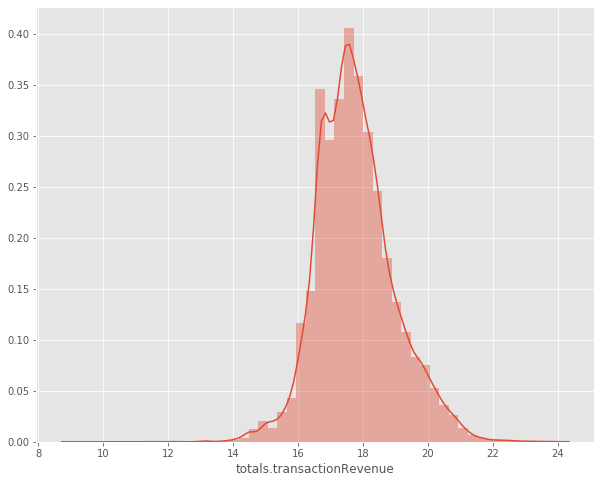

In [51]:
plt.figure(figsize=(10,8))
nzr = log_revenue[log_revenue>0]
sns.distplot(nzr)

In [52]:
from scipy.stats import kurtosis, skew
total = nzr
print("The skewness of the transaction value ", skew(total))
print("The kurtosis of the transaction value ", kurtosis(total))

The skewness of the transaction value  0.3809221371038405
The kurtosis of the transaction value  1.0575313763811511


- skewness is just 0.3, so it is almost symmetrical
- kurtosis is more than 1 shows that it is little sharp i.e, not a perfect bell shaped curve

<h3> 3.2.3 channelGrouping distro</h3>

In [53]:
#https://www.kaggle.com/smasar/tutorial-preprocessing-processing-evaluation

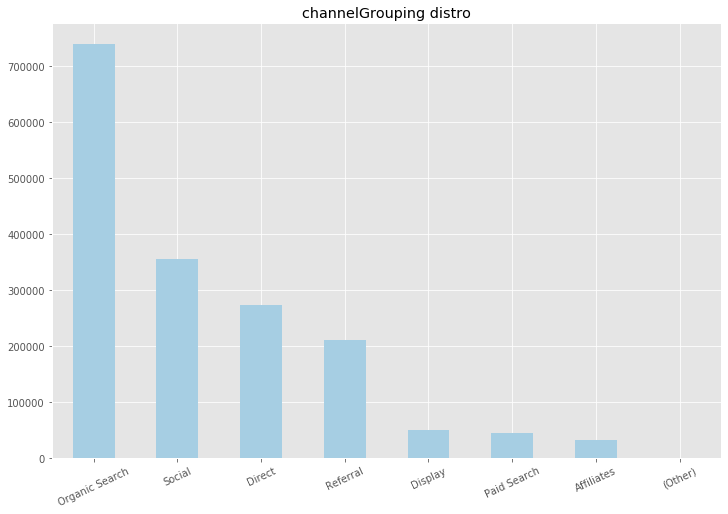

In [54]:
train_df.channelGrouping.value_counts().plot(kind="bar",title="channelGrouping distro",figsize=(12,8),rot=25,colormap='Paired')

 <h3> 3.2.4   DATE&VISIT_START_TIME </h3>

There are two varialbe related to time and can be used in time dependent analyzes specially TimeSeries.

In [55]:
"date :{}, visitStartTime:{}".format(train_df.head(1).date[0],train_df.head(1).visitStartTime[0])

'date :20171016, visitStartTime:1508198450'

date is stored in String and should be converted to pandas datetime format. visitStartTime is stored in epoch unix format and should be converted to pandas datetime format. doing the correspondence transforms and storing on the same attribute.

In [56]:
from datetime import datetime as dt

In [57]:
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
   # df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df #returning the df after the transformations

In [58]:
train_df = date_process(train_df)
test_df = date_process(test_df)

In [59]:
#train_df["visitStartTime"] = pd.to_datetime(train_df["visitStartTime"],unit='s')
#test_df["visitStartTime"] = pd.to_datetime(test_df["visitStartTime"],unit='s')

In [60]:
train_df.head(5)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,_weekday,_day,_month,_year
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,1,0.0,NaN,(not set),NaN,water bottle,organic,NaN,google,0,16,10,2017
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,2,NaN,2,0.0,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,0,16,10,2017
2,Direct,2017-10-16,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,NaN,2,1,2,0.0,NaN,(not set),True,NaN,(none),NaN,(direct),0,16,10,2017
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,NaN,2,1,2,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google,0,16,10,2017
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,NaN,2,1,2,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google,0,16,10,2017


### Date fields

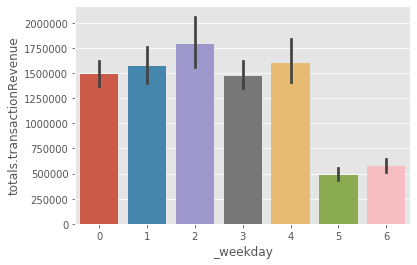

In [61]:
sns.barplot(x=train_df['_weekday'], y=train_df['totals.transactionRevenue'], data=train_df)

here we can see weekday 5 and 6 is generate less revenue

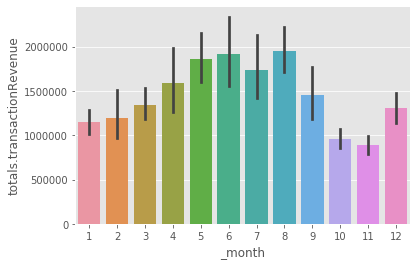

In [62]:
sns.barplot(x=train_df['_month'], y=train_df['totals.transactionRevenue'], data=train_df)

here we can see 5th 6th abd 7th month give more revenue

In [63]:
#plt.figure(figsize=(16,8))
#sns.barplot(x=train_df['week'], y=train_df['totals.transactionRevenue'], data=train_df)

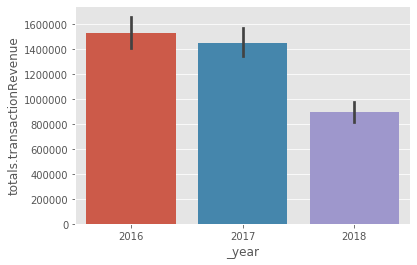

In [64]:
sns.barplot(x=train_df['_year'], y=train_df['totals.transactionRevenue'], data=train_df)

so here we see the revenue is decreasing every year and highest revenue give in 2016 and 2017

In [3]:
#plt.figure(figsize=(16,8))
#sns.barplot(x=train_df['_visitHour'], y=train_df['totals.transactionRevenue'], data=train_df)

### function to plot attributes

In [66]:
#https://github.com/abdkumar/Google-Analytics-Customer-Revenue-Prediction/blob/master/customer%20revenue%20prediction.ipynb
def category_plots(col):
    a = train_df.loc[:,[col, 'totals.transactionRevenue']]
    a['totals.transactionRevenue'] = a['totals.transactionRevenue'].replace(0.0, np.nan)
    cnt_srs = a.groupby(col)['totals.transactionRevenue'].agg(['size','count','mean'])
    cnt_srs.columns = ["count", 'count of non-zero revenue', "mean transaction value"]

    cnt_srs['total_revenue'] = cnt_srs['count of non-zero revenue']*cnt_srs['mean transaction value']
    cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
    #print(cnt_srs.head(10))
    plt.figure(figsize=(8, 20)) 
    plt.subplot(4,1,1)
    sns.barplot(x=cnt_srs['count'].head(10), y=cnt_srs.index[:10],color='tan')
    plt.subplot(4,1,2)
    sns.barplot(x=cnt_srs['count of non-zero revenue'].head(10), y=cnt_srs.index[:10],color='teal')
    plt.subplot(4,1,3)
    sns.barplot(x=cnt_srs['mean transaction value'].head(10), y=cnt_srs.index[:10],color='lime')
    plt.subplot(4,1,4)
    sns.barplot(x=cnt_srs['total_revenue'].head(10), y=cnt_srs.index[:10],color='c')

<h3>3.2.5  DEVICE </h3>

#### device.browser

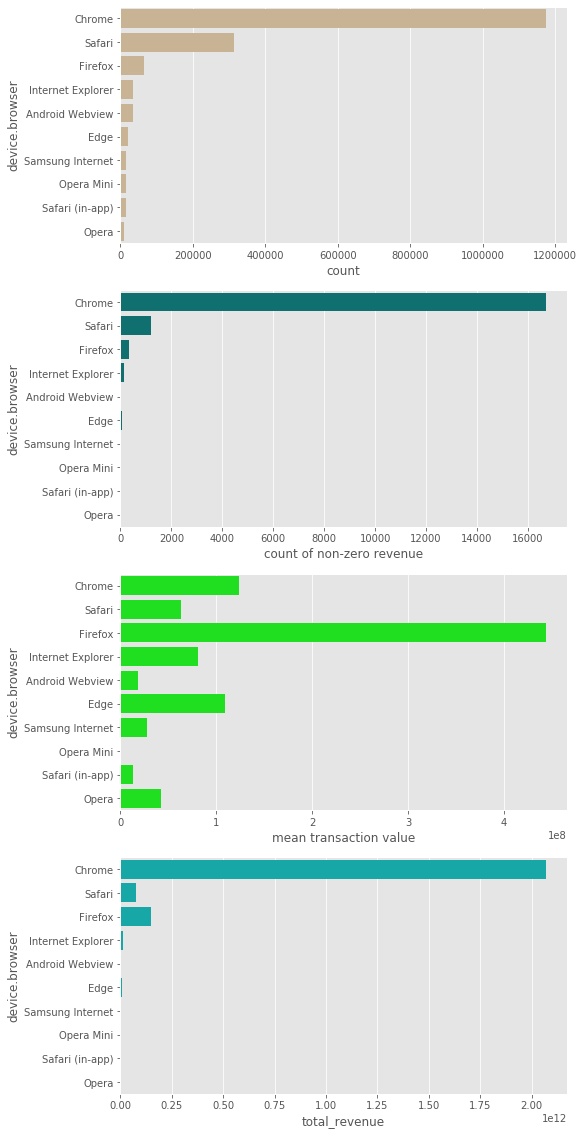

In [67]:
category_plots('device.browser')

- here is top three browsers like chrome safari firefox
- most of the revenue generate form chrome .
- firefox has mean transection value high.

#### device.operatingSystem

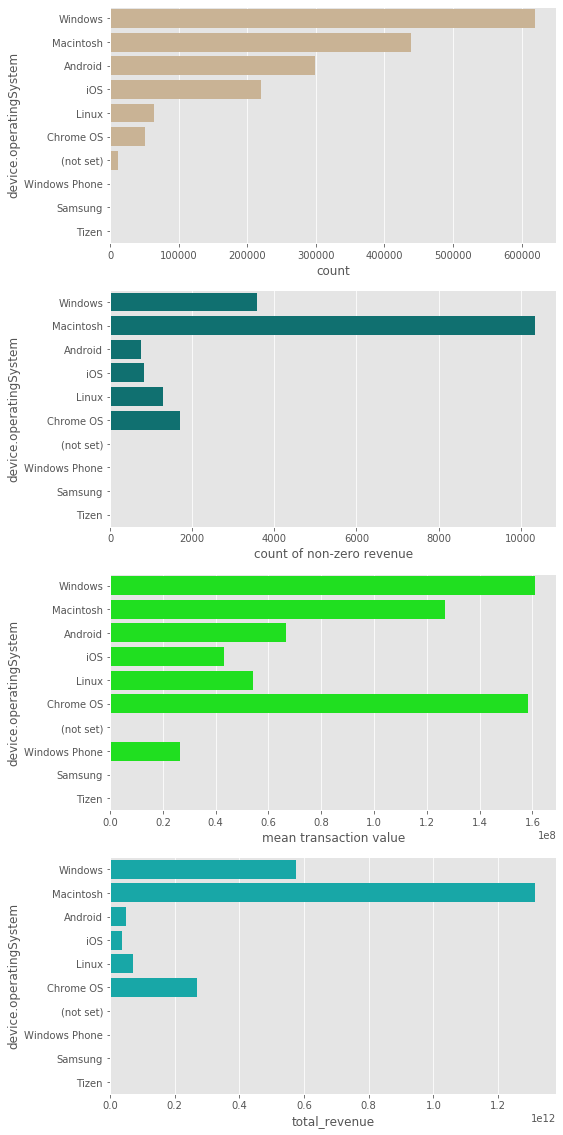

In [68]:
category_plots('device.operatingSystem')

-  we can see that most of the revenue generate from windows macintosh and chrome os
-  and most use os is  windows macintosh android and ios

#### device.deviceCategory

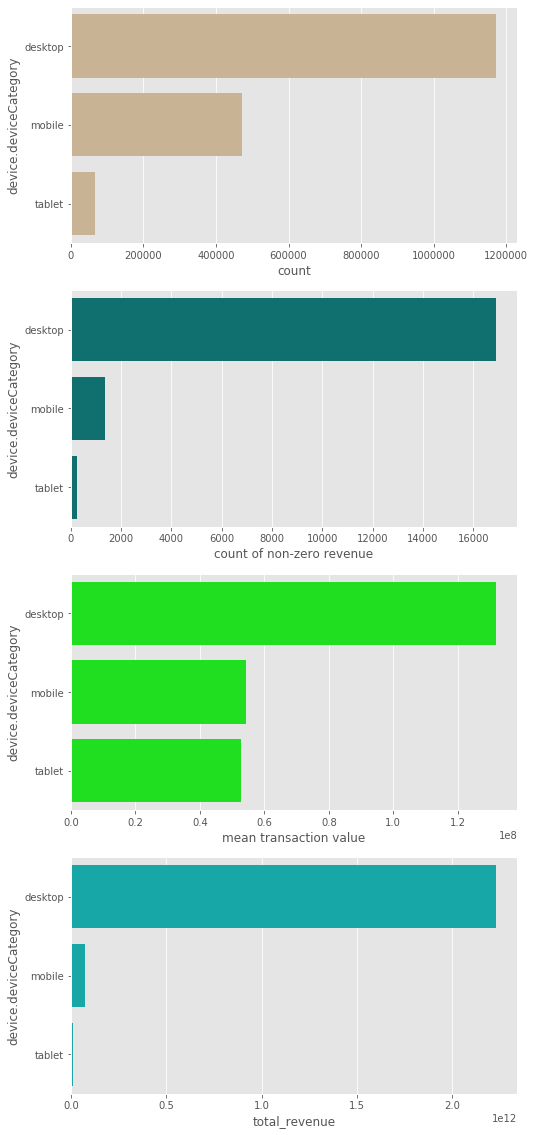

In [69]:
category_plots('device.deviceCategory')

-  most so here is a only desktop is more use and more revenue generate.

<h3>3.2.6  Geonetwork category </h3>

#### geoNetwork.continent

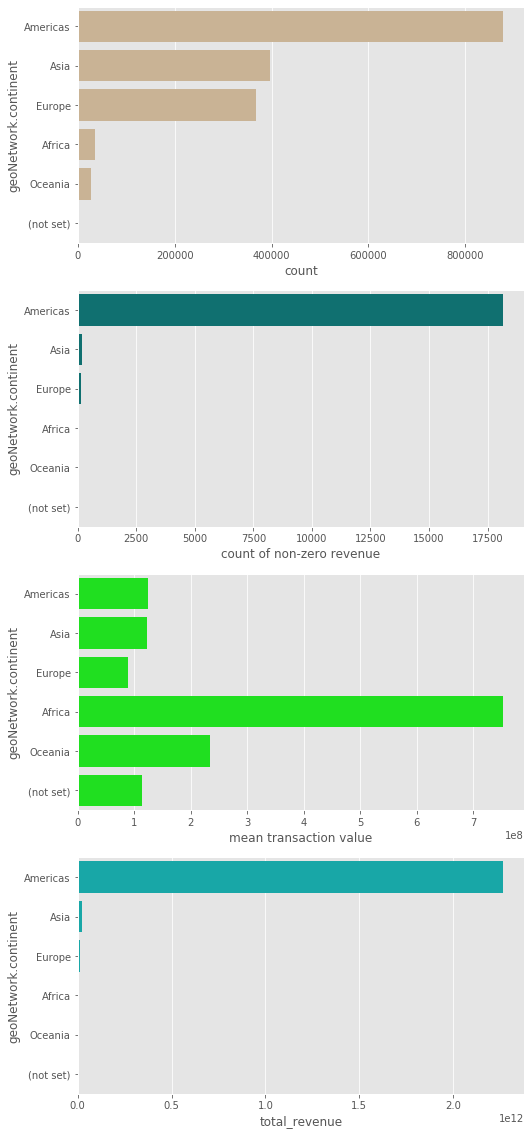

In [70]:
category_plots('geoNetwork.continent')

-  here we can se only amaericas are help to generate more revenue.

#### geoNetwork.country

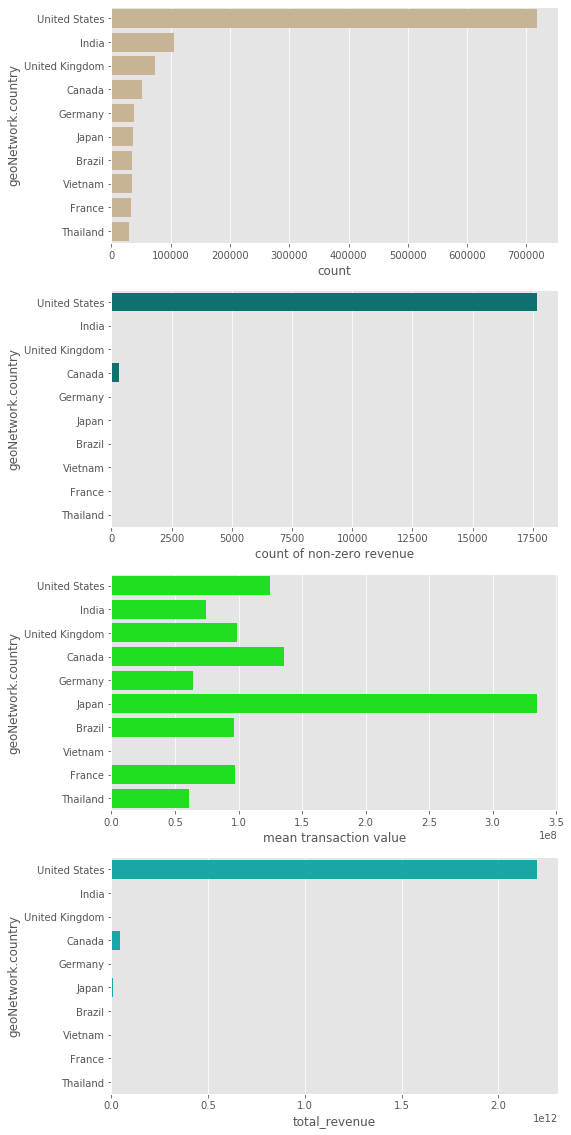

In [71]:
category_plots('geoNetwork.country')

-  united states is generate more revenue .

#### geoNetwork.networkDomain

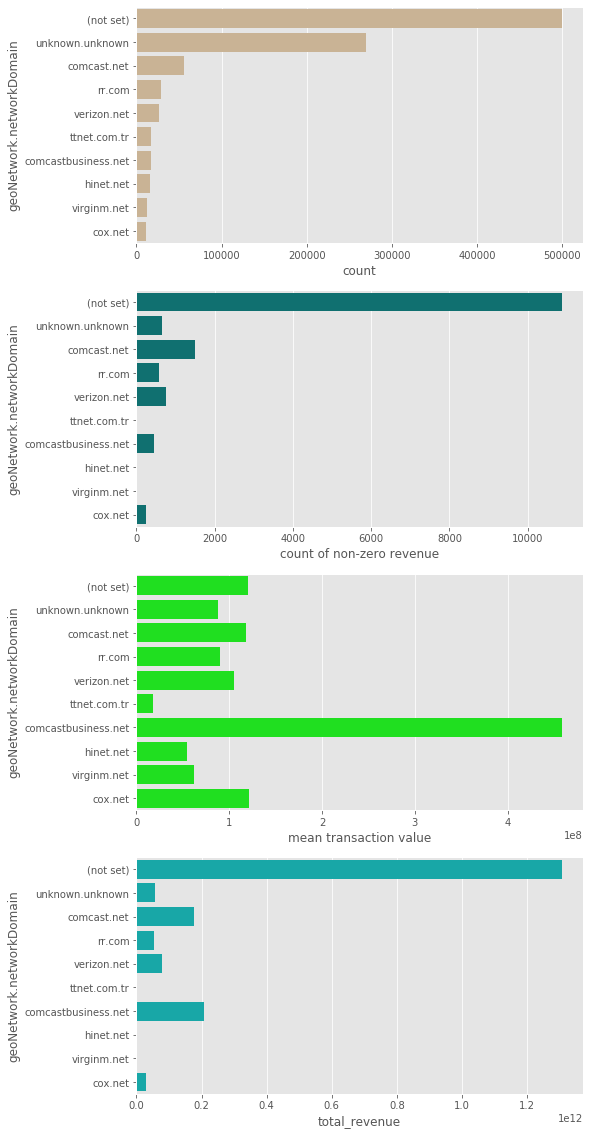

In [72]:
category_plots('geoNetwork.networkDomain')

- here we can not says any thing becouse this (not set) .

<h3>3.2.7  traffic Source category </h3> 

#### trafficSource.medium

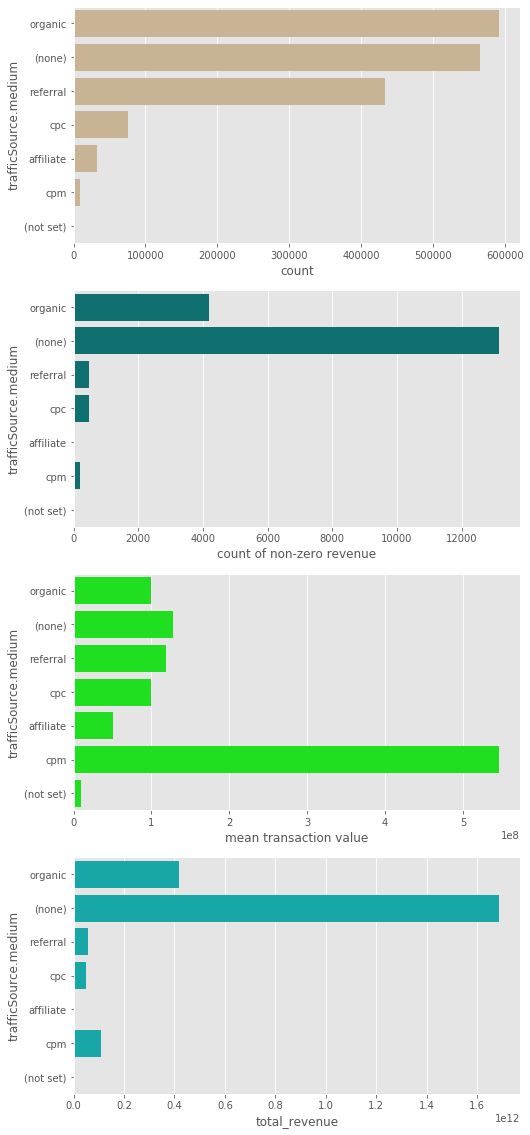

In [73]:
category_plots('trafficSource.medium')

- most of the revenue generate from organic medium .

#### trafficSource.campaign

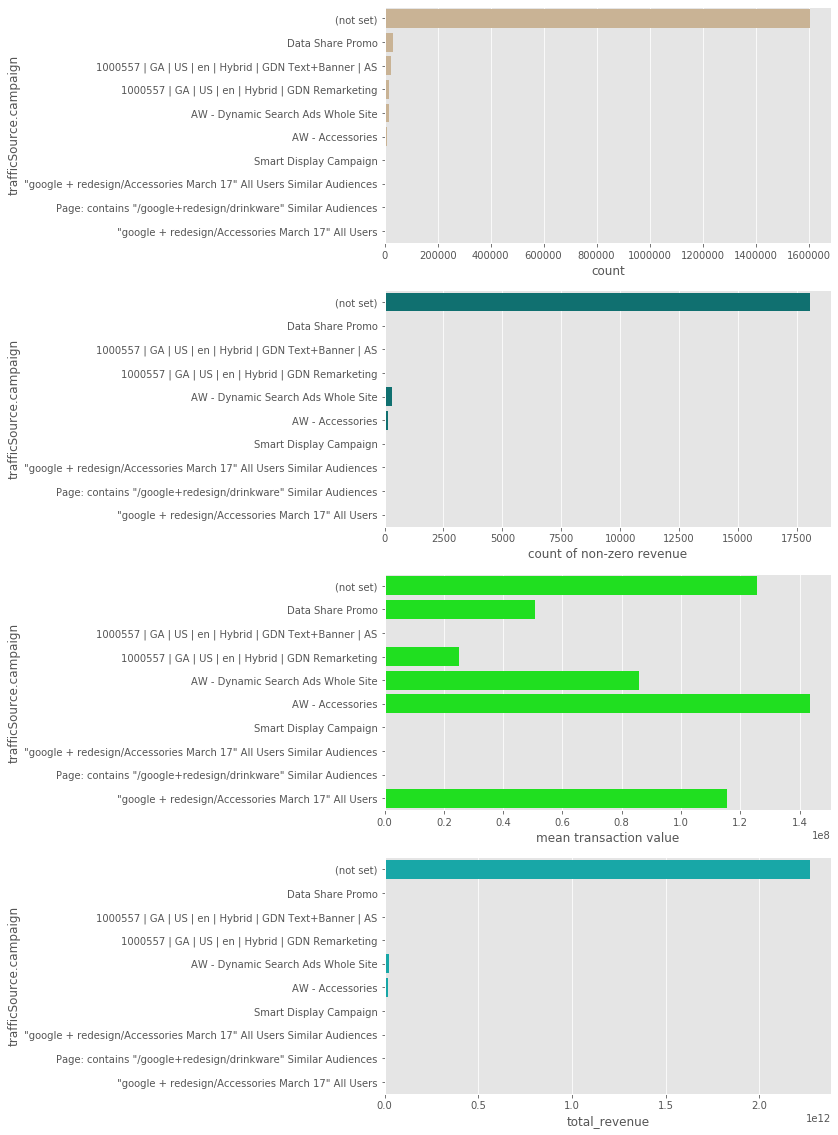

In [74]:
category_plots('trafficSource.campaign')

#### trafficSource.adContent

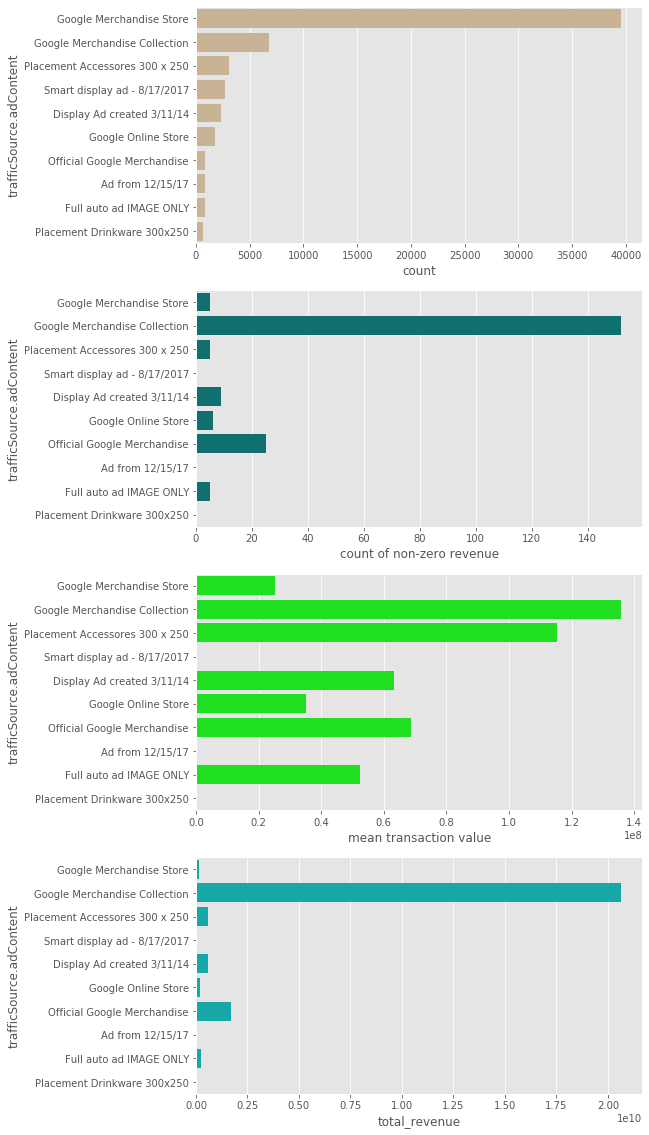

In [75]:
category_plots('trafficSource.adContent')

- here we can see that google merchandise collection have totle revenue and litil bit .

#### trafficSource.referralPath

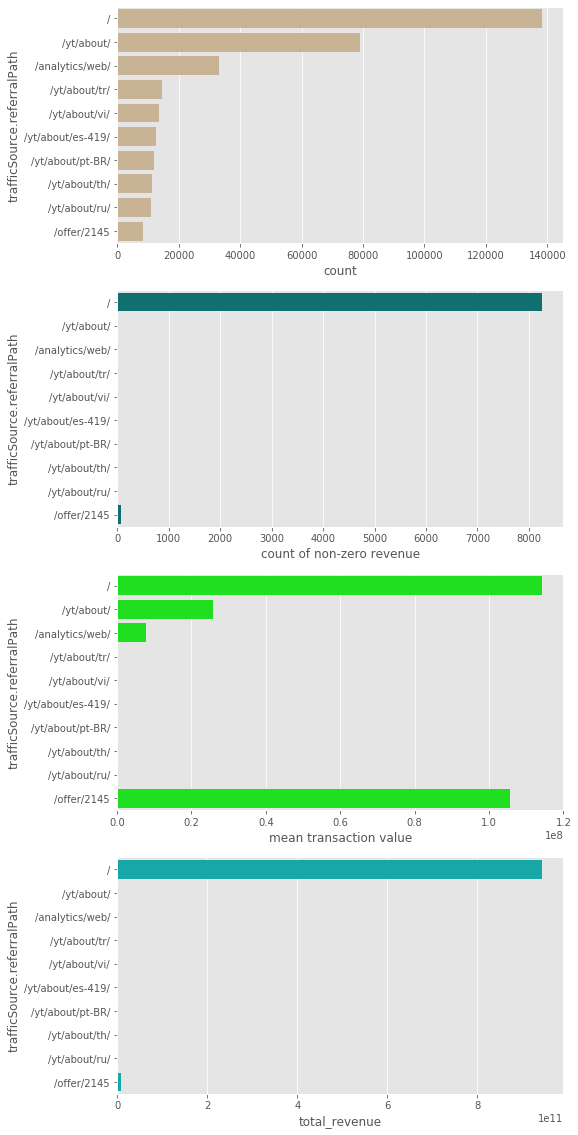

In [76]:
category_plots('trafficSource.referralPath')

#### trafficSource.source

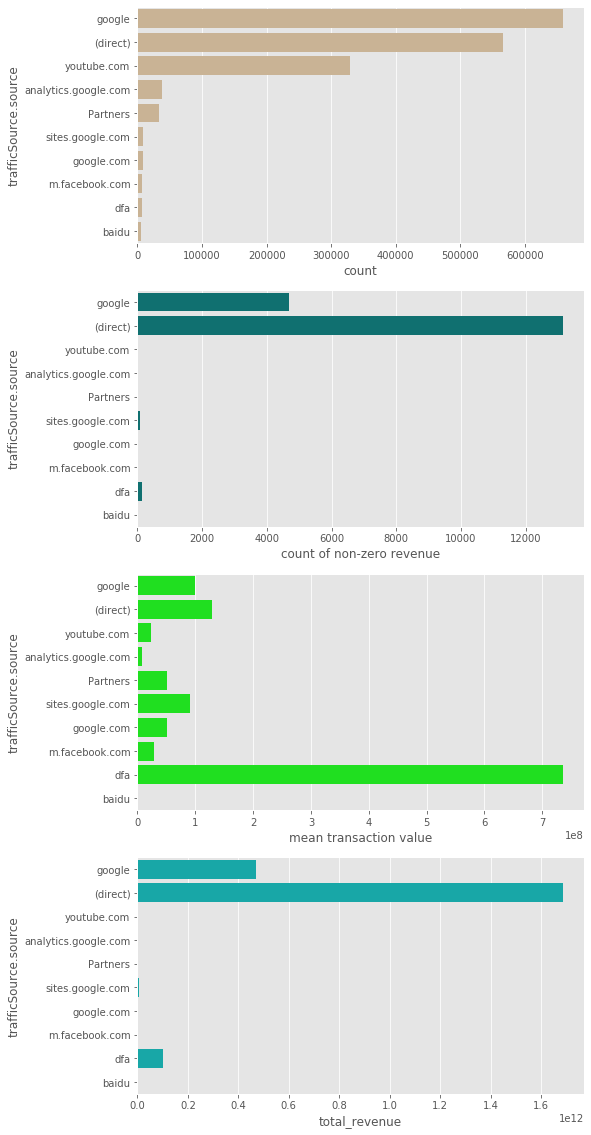

In [77]:
category_plots('trafficSource.source')

- most of them are direct ans google make good revenue

# 4 Data Cleaning 

#### 4.1 drop the columns

In [78]:
#not usefull columns
col_drop=["totals.bounces","trafficSource.referralPath","trafficSource.keyword","trafficSource.campaign"]

In [79]:
train=train_df.drop(col_drop,axis=1)#drop the columns on train set

In [80]:
test=test_df.drop(col_drop,axis=1)#drop the columns on test set

In [81]:
train.shape

(1708337, 29)

In [82]:
test.shape

(401589, 29)

#### 4.2 concat and Correct dtypes

In [86]:
train_test_data = pd.concat([train,test], axis=0).reset_index()#concat the train and test data

In [87]:
#change the data types
train_test_data['totals.hits'] = train_test_data['totals.hits'].astype(float)
train_test_data['totals.pageviews'] = train_test_data['totals.pageviews'].astype(float)
train_test_data['totals.newVisits'] = train_test_data['totals.newVisits'].astype(float)
train_test_data['device.isMobile'] = train_test_data['device.isMobile'].astype(bool)
train_test_data['trafficSource.isTrueDirect'] = train_test_data['trafficSource.isTrueDirect'].astype(bool)

#### 4.3 fill the missing value

In [88]:
#fill the missing values in transactionrevenue columns
train_test_data['totals.transactionRevenue'] = train_test_data['totals.transactionRevenue'].astype(float)
train_test_data['totals.transactionRevenue'].fillna(0, inplace=True)#fill the null vale with 0
target = train_test_data['totals.transactionRevenue']#store in a new variable

### 5 feature engineering

- function includes getting:
- dataframe of fixed time-interval of 168 days
- revisited customers from the next fixed interval of 62 days (after 46 days from the first interval)
- features from the first interval to predict target on the second interval

Train creation
As we have 168 days (2018/05/01-2018/10/15) of sessions for customers in the test, 62 days (2018/12/01-2019/01/31) of target calculation period and 46 days (16/10/2018-30/11/2018) of gap between above two windows, it’s absolutely clear to construct train data by analogy.
I took 4 non-overlapping windows of 168 days, calculated features for users in each period and calculated target for each user on each corresponding 62-day window. Then those 4 dataframes were combined in one train set.

- https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/82614

In [89]:
#https://github.com/HuanZhang999/GoogleAnalyticsCustomerRevenuePrediction/blob/master/1-%20create_train.ipynb
def getTimeFramewithFeatures(tr, k=1):
    #fetch the all data form the min date to 168 days and store in tf data frame . 
    tf = train_test_data.loc[(train_test_data['date'] >= min(train_test_data['date']) + timedelta(days=168*(k-1))) 
              & (train_test_data['date'] < min(train_test_data['date']) + timedelta(days=168*k))]
    #here we fetch fullvisiterid of user those return in test time like in 62 days 
    tf_fvid = set(train_test_data.loc[(train_test_data['date'] >= min(train_test_data['date']) + timedelta(days=168*k + 46 )) 
                       & (train_test_data['date'] < min(train_test_data['date']) + timedelta(days=168*k + 46 + 62))]['fullVisitorId'])
    #here we see fvid is in the "tf" or not and create returned variable 
    tf_returned = tf[tf['fullVisitorId'].isin(tf_fvid)]
    
    #all do it for test data as well 
    tf_tst = train_test_data[train_test_data['fullVisitorId'].isin(set(tf_returned['fullVisitorId']))
             & (train_test_data['date'] >= min(train_test_data['date']) + timedelta(days=168*k + 46))
             & (train_test_data['date'] < min(train_test_data['date']) + timedelta(days=168*k + 46 + 62))]
    
    #know we groupby the fullvisiterid and transection and apply log on it.
    tf_target = tf_tst.groupby('fullVisitorId')[['totals.transactionRevenue']].sum().apply(np.log1p, axis=1).reset_index()
    tf_target['ret'] = 1 #if the user id return  then store 1 in the column
    tf_target.rename(columns={'totals.transactionRevenue': 'target'}, inplace=True)#remane the columns 
    
    tf_nonret = pd.DataFrame()#create new data frame for not return users 
    tf_nonret['fullVisitorId'] = list(set(tf['fullVisitorId']) - tf_fvid)#we find the list of user not return use set funstion     
    tf_nonret['target'] = 0#store 0 on target
    tf_nonret['ret'] = 0#store 0 on return
    
    #concate both the data frame 
    tf_target = pd.concat([tf_target, tf_nonret], axis=0).reset_index(drop=True)
    
    tf_maxdate = max(tf['date'])#find the max date form tf
    tf_mindate = min(tf['date'])#find the min date form tf
    
    #apply groupby on every single row an add new feature also. 
    tf = tf.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': {'networkDomain': lambda x: x.dropna().max()},
            'geoNetwork.city': {'city': lambda x: x.dropna().max()},
            'device.operatingSystem': {'operatingSystem': lambda x: x.dropna().max()},
            'geoNetwork.metro': {'metro': lambda x: x.dropna().max()},
            'geoNetwork.region': {'region': lambda x: x.dropna().max()},
            'channelGrouping': {'channelGrouping': lambda x: x.dropna().max()},
    
            'geoNetwork.country': {'country': lambda x: x.dropna().max()},
            'trafficSource.source': {'source': lambda x: x.dropna().max()},
            'trafficSource.medium': {'medium': lambda x: x.dropna().max()},
            'device.browser':  {'browser': lambda x: x.dropna().max()},
            'device.deviceCategory': {'deviceCategory': lambda x: x.dropna().max()},
            'geoNetwork.continent': {'continent': lambda x: x.dropna().max()},
            'totals.pageviews': {'pageviews_sum': lambda x: x.dropna().sum(),
                                 'pageviews_min': lambda x: x.dropna().min(), 
                                 'pageviews_max': lambda x: x.dropna().max(),
                                 'pageviews_mean': lambda x: x.dropna().mean()},
            'totals.hits': {'hits_sum': lambda x: x.dropna().sum(), 
                            'hits_min': lambda x: x.dropna().min(), 
                            'hits_max': lambda x: x.dropna().max(), 
                            'hits_mean': lambda x: x.dropna().mean()},
    
            'visitStartTime': {'visitStartTime_counts': lambda x: x.dropna().count()},
            'trafficSource.isTrueDirect': {'isTrueDirect': lambda x: x.dropna().max()},
            'totals.newVisits': {'newVisits_max': lambda x: x.dropna().max()},
            'device.isMobile': {'isMobile': lambda x: x.dropna().max()},
            'visitNumber': {'visitNumber_max' : lambda x: x.dropna().max()},
    
            'totals.transactionRevenue':  {'transactionRevenue_sum':  lambda x:x.dropna().sum()},
            
            'date': {'first_ses_from_the_period_start': lambda x: x.dropna().min() - tf_mindate,
                     
                     'last_ses_from_the_period_end': lambda x: tf_maxdate - x.dropna().max(),
                     
                     'interval_dates': lambda x: x.dropna().max() - x.dropna().min(),
                     
                     'unqiue_date_num': lambda x: len(set(x.dropna())) },            
                    })

    tf.columns = tf.columns.droplevel()#droplevel function to drop the 0th level of the MultiIndex.
    
    #merge all tf and tf_target data frame 
    tf = pd.merge(tf, tf_target, left_on='fullVisitorId', right_on='fullVisitorId')
    return tf

In [90]:
print('Get 1st train part...')
tr1 = getTimeFramewithFeatures(train_test_data, k=1)#fuction call with k=1
tr1.to_pickle("E:\\data science case studys\\new_tr1_clean")#save the data into pickle

Get 1st train part...


C:\Anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


In [91]:
%%time
print('Get 2st train part...')
tr2 = getTimeFramewithFeatures(train_test_data, k=2)
tr2.to_pickle("E:\\data science case studys\\new_tr2_clean")

Get 2st train part...
Wall time: 2h 12min 23s


In [92]:
%%time
print('Get 2st train part...')
tr3 = getTimeFramewithFeatures(train_test_data, k=3)
tr3.to_pickle("E:\\data science case studys\\new_tr3_clean")

Get 2st train part...
Wall time: 2h 55min 45s


In [93]:
%%time
print('Get 2st train part...')
tr4 = getTimeFramewithFeatures(train_test_data, k=4)
tr4.to_pickle("E:\\data science case studys\\new_tr4_clean")

Get 2st train part...
Wall time: 2h 47min 35s


In [98]:
### Construction of the test-set (by analogy as train-set)
print('Get test')
#change the date fomate and find the date which >=2018-05-01 
tr5 = train_test_data[train_test_data['date'] >= pd.to_datetime(20180501, infer_datetime_format=True, format="%Y%m%d")]
tf_maxdate = max(tr5['date'])#fetch max date
tf_mindate = min(tr5['date'])#fetch min date

Get test


#### Do it for test data as well

In [99]:
%%time
tr5 = tr5.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': {'networkDomain': lambda x: x.dropna().max()},
            'geoNetwork.city': {'city': lambda x: x.dropna().max()},
            'device.operatingSystem': {'operatingSystem': lambda x: x.dropna().max()},
            'geoNetwork.metro': {'metro': lambda x: x.dropna().max()},
            'geoNetwork.region': {'region': lambda x: x.dropna().max()},
            'channelGrouping': {'channelGrouping': lambda x: x.dropna().max()},
    
            'geoNetwork.country': {'country': lambda x: x.dropna().max()},
            'trafficSource.source': {'source': lambda x: x.dropna().max()},
            'trafficSource.medium': {'medium': lambda x: x.dropna().max()},
            'device.browser':  {'browser': lambda x: x.dropna().max()},
            'device.deviceCategory': {'deviceCategory': lambda x: x.dropna().max()},
            'geoNetwork.continent': {'continent': lambda x: x.dropna().max()},
            'totals.pageviews': {'pageviews_sum': lambda x: x.dropna().sum(),
                                 'pageviews_min': lambda x: x.dropna().min(), 
                                 'pageviews_max': lambda x: x.dropna().max(),
                                 'pageviews_mean': lambda x: x.dropna().mean()},
            'totals.hits': {'hits_sum': lambda x: x.dropna().sum(), 
                            'hits_min': lambda x: x.dropna().min(), 
                            'hits_max': lambda x: x.dropna().max(), 
                            'hits_mean': lambda x: x.dropna().mean()},
    
            'visitStartTime': {'visitStartTime_counts': lambda x: x.dropna().count()},
            'trafficSource.isTrueDirect': {'isTrueDirect': lambda x: x.dropna().max()},
            'totals.newVisits': {'newVisits_max': lambda x: x.dropna().max()},
            'device.isMobile': {'isMobile': lambda x: x.dropna().max()},
            'visitNumber': {'visitNumber_max' : lambda x: x.dropna().max()},
    
            'totals.transactionRevenue':  {'transactionRevenue_sum':  lambda x:x.dropna().sum()},
            
            'date': {'first_ses_from_the_period_start': lambda x: x.dropna().min() - tf_mindate,
                     
                     'last_ses_from_the_period_end': lambda x: tf_maxdate - x.dropna().max(),
                     
                     'interval_dates': lambda x: x.dropna().max() - x.dropna().min(),
                     
                     'unqiue_date_num': lambda x: len(set(x.dropna())) },            
                    })
tr5.columns = tr5.columns.droplevel()
tr5['target'] = np.nan#store the null value in target column
tr5['ret'] = np.nan#store the null value in return column

Wall time: 2h 22min 57s


In [97]:
tr5.to_pickle("E:\\data science case studys\\new_tr5_clean")

### 6: load the pickle files 

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [187]:
path="E:\\data science case studys\\"#define the path of your file where you save pickle files 

In [188]:
%%time
new_tr1 = pd.read_pickle(path+"new_tr1_clean")#read file

Wall time: 27.9 s


In [189]:
%%time
new_tr2 = pd.read_pickle(path+"new_tr2_clean")

Wall time: 25.2 s


In [190]:
%%time
new_tr3 = pd.read_pickle(path+"new_tr3_clean")

Wall time: 29 s


In [191]:
%%time
new_tr4 = pd.read_pickle(path+"new_tr4_clean")

Wall time: 29.7 s


In [192]:
%%time
new_tr5 = pd.read_pickle(path+"new_tr5_clean")

Wall time: 42.6 s


##### 6.1 Concat all the train data set and feature engineering

In [193]:
#concat all the train data set 
train_all = pd.concat([new_tr1,new_tr2,new_tr3,new_tr4,new_tr5], axis=0, sort=False).reset_index(drop=True)
#fetch the days and store into the same columns where we fetch days 
train_all['interval_dates'] = train_all['interval_dates'].dt.days
train_all['first_ses_from_the_period_start'] = train_all['first_ses_from_the_period_start'].dt.days
train_all['last_ses_from_the_period_end'] = train_all['last_ses_from_the_period_end'].dt.days

In [194]:
train_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819164 entries, 0 to 1819163
Data columns (total 61 columns):
fullVisitorId                      object
networkDomain                      object
city                               object
operatingSystem                    object
metro                              object
region                             object
channelGrouping                    object
country                            object
source                             object
medium                             object
browser                            object
deviceCategory                     object
continent                          object
pageviews_sum                      float64
pageviews_min                      float64
pageviews_max                      float64
pageviews_mean                     float64
hits_sum                           float64
hits_min                           float64
hits_max                           float64
hits_mean                          float

## pageview

In [0]:
#train_all['sum_pageviews_sum_networkDomain'] = train_all.groupby('networkDomain')['pageviews_sum'].transform('sum').astype('int')
#train_all['min_pageviews_min_networkDomain'] = train_all.groupby('networkDomain')['pageviews_min'].transform('min').astype('int')
#train_all['max_pageviews_max_networkDomain'] = train_all.groupby('networkDomain')['pageviews_max'].transform('max').astype('int')
#train_all['mean_pageviews_max_networkDomain'] = train_all.groupby('networkDomain')['pageviews_mean'].transform('mean').astype('int')

#### hits

In [0]:
#train_all['mean_hits_sum_networkDomain'] = train_all.groupby('networkDomain')['hits_sum'].transform('max').astype('int')
#train_all['mean_hits_min_networkDomain'] = train_all.groupby('networkDomain')['hits_min'].transform('max').astype('int')
#train_all['mean_hits_max_networkDomain'] = train_all.groupby('networkDomain')['hits_max'].transform('max').astype('int')

In [291]:
fullVisitorId_new=new_tr5.index #store the index of test data use for create submission file.

### 7: Label encoding and feature standardization

In [197]:
not_use=["target","ret"]#define the list of columns which we not want to standardize or encode

In [198]:
#fatch only categorical data
categorical_cols = list()
for i in train_all.columns:
    if (train_all[i].dtype=='object' or train_all[i].dtype=='bool'):#it contain only object and bool type columns 
        categorical_cols.append(i)#add into list 

In [199]:
#fatch only numerical data
num_cols = list()
for i in train_all.columns:#loop run for all the train columns 
    if train_all[i].dtype not in ['object', 'bool']:#it remove all the object and bool columns ans contain only numerical columnse
        num_cols.append(i)#add the columns into list
#num_cols        
numerical_columns = [c for c in num_cols if c not in not_use]#and here we remove not use columns
numerical_columns

['pageviews_sum',
 'pageviews_min',
 'pageviews_max',
 'pageviews_mean',
 'hits_sum',
 'hits_min',
 'hits_max',
 'hits_mean',
 'visitStartTime_counts',
 'newVisits_max',
 'visitNumber_max',
 'transactionRevenue_sum',
 'first_ses_from_the_period_start',
 'last_ses_from_the_period_end',
 'interval_dates',
 'unqiue_date_num',
 'index',
 'date',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'totals.transactionRevenue',
 '_weekday',
 '_day',
 '_month',
 '_year']

In [200]:
categorical_cols

['fullVisitorId',
 'networkDomain',
 'city',
 'operatingSystem',
 'metro',
 'region',
 'channelGrouping',
 'country',
 'source',
 'medium',
 'browser',
 'deviceCategory',
 'continent',
 'isTrueDirect',
 'isMobile',
 'device.browser',
 'device.deviceCategory',
 'device.isMobile',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'trafficSource.adContent',
 'trafficSource.isTrueDirect',
 'trafficSource.medium',
 'trafficSource.source']

In [202]:
def str_to_bool(s):
    if s == 'True':
         return True
    elif s == 'False':
         return False
    else:
         return False  #ValueError # evil ValueError that doesn't tell you what the wrong value was

In [203]:
train_all["isTrueDirect"]=train_all["isTrueDirect"].apply(lambda x : str_to_bool(x))
train_all["isMobile"]=train_all["isMobile"].apply(lambda x : str_to_bool(x))
train_all["device.isMobile"]=train_all["device.isMobile"].apply(lambda x : str_to_bool(x))
train_all["trafficSource.isTrueDirect"]=train_all["trafficSource.isTrueDirect"].apply(lambda x : str_to_bool(x))

In [17]:
#train_all.isnull().sum()

In [204]:
#categorical_cols.remove("fullVisitorId")
categorical_cols.remove("isTrueDirect")
categorical_cols.remove("isMobile")
categorical_cols.remove("device.isMobile")
categorical_cols.remove("trafficSource.isTrueDirect")

#### 7.1 fill missing values

In [205]:
# fillmissing 
for col in categorical_cols:
    train_all[col].fillna('missing', inplace=True)#fill the all missing  value with  "missing" in categorical data

for col in numerical_columns:       
    train_all[col].fillna(0,inplace=True)#fill the all missing  value with  "0" in numerical  data

In [206]:
#categorical_cols.remove("fullVisitorId")
numerical_columns.remove("date")

# seprate the test and train data by useig notnull() and isnull() and lable encodeing

In [207]:
'''les = []
for col in categorical_cols:
    le = preprocessing.LabelEncoder()
    le.fit(train_all[col])
    les.append(le)
    train_all[col] = le.transform(train_all[col])'''
    
# standardize the num_cols

# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(train_all[numerical_columns])
scaled_df = pd.DataFrame(scaled_df, columns=numerical_columns)
train_all[numerical_columns] = scaled_df

In [208]:
train = train_all[train_all['target'].notnull()]#fetch the column and row where target column notnull 

In [209]:
test = train_all[train_all['target'].isnull()]#fetch the column and row where target column isnull

#### 7.2 label encoding 

### categorical_cols train and test data

In [210]:
categorical_cols.remove("fullVisitorId")
#categorical_cols

In [211]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [212]:
for col in categorical_cols:
    # Using whole data to form an exhaustive list of levels
    data=train[col].append(test[col])
    le.fit(data.values)
    train[col]=le.transform(train[col])
    test[col]=le.transform(test[col])

In [213]:
print("train data :", train.shape," test data :",test.shape)

train data : (1417575, 61)  test data : (401589, 61)


## 8: model
- https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

### 8.1 LogisticRegression and LinearRegression

In [214]:
target_cols = ['target','ret','fullVisitorId']
x_train=train[categorical_cols+numerical_columns]
y_train=train['ret']

In [215]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from catboost import CatBoostRegressor
import catboost as cgb
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold,train_test_split

In [216]:
grid={"C":[10,20,30], "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 30, 'penalty': 'l2'}
accuracy : 0.9938535880009685


In [217]:
X_train_reg=train[categorical_cols+numerical_columns][train['ret']==1]
y_train_reg=train['target'][train['ret']==1]

In [218]:
from sklearn import linear_model
model = linear_model.LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model,parameters, cv=None)
grid.fit(X_train_reg, y_train_reg)

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [219]:
text=test[categorical_cols+numerical_columns]

In [220]:
pred_clas=logreg_cv.predict(text)
pred_reg=grid.predict(text)

In [221]:
final_pred=(pred_clas+pred_reg)

In [255]:
new_data=pd.DataFrame()#create new data frame
new_data["fullVisitorId"]=fullVisitorId_new.astype(str)#store new visiterid 
new_data["PredictedLogRevenue"]=final_pred#store the pridected values 
new_data.to_csv("E:\\data science case studys\\lr_grg_2.csv", index=False)#create a csv file 

##### Private Score is 2.2333

### 8.2 RandomForestClassifier

In [228]:
grid={"max_depth":[2,5,7,9]}
rfclas=RandomForestClassifier(random_state=0)
rfclas_cv=GridSearchCV(rfclas,grid,cv=5)
rfclas_cv.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",rfclas_cv.best_params_)
print("accuracy :",rfclas_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 9}
accuracy : 0.99387616175511


In [229]:
from sklearn.ensemble import RandomForestRegressor

In [230]:
grid={"max_depth":[2,5,7,9]}
rfreg=RandomForestRegressor(random_state=0)
rfreg_cv=GridSearchCV(rfreg,grid,cv=5)
rfreg_cv.fit(X_train_reg,y_train_reg)
print("tuned hpyerparameters :(best parameters) ",rfreg_cv.best_params_)
print("accuracy :",rfreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 5}
accuracy : 0.0701792488164388


In [231]:
pred_clas=rfclas_cv.predict(text)
pred_reg=rfreg_cv.predict(text)
final_ref=(pred_clas+pred_reg)

In [259]:
new_data=pd.DataFrame()#create new data frame
new_data["fullVisitorId"]=fullVisitorId_new.astype(str)#store new visiterid 
new_data["PredictedLogRevenue"]=final_ref#store the pridected values 
new_data.to_csv("E:\\data science case studys\\final_ref.csv", index=False)#create a csv file 

###### Private Score is 1.954

### 8.3 Decision Trees with GridSearchCV

In [232]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth':np.arange(3,10,2)}
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt,param_grid=parameters, n_jobs=-1)
dt_grid.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",dt_grid.best_params_)
print("accuracy :",dt_grid.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 5}
accuracy : 0.9938634640142496


In [233]:
from sklearn.tree import DecisionTreeRegressor

In [234]:
parameters = {'max_depth':np.arange(3,10,2)}
dt = DecisionTreeRegressor()
dt_grid_reg = GridSearchCV(dt,param_grid=parameters, n_jobs=-1)
dt_grid_reg.fit(X_train_reg,y_train_reg)
print("tuned hpyerparameters :(best parameters) ",dt_grid_reg.best_params_)
print("accuracy :",dt_grid_reg.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 3}
accuracy : 0.052630812989835275


In [235]:
pred_clas=dt_grid.predict(text)
pred_reg=dt_grid_reg.predict(text)
final_dt=(pred_clas+pred_reg)

In [256]:
new_data=pd.DataFrame()#create new data frame
new_data["fullVisitorId"]=fullVisitorId_new#store new visiterid 
new_data["PredictedLogRevenue"]=final_dt#store the pridected values 
new_data.to_csv("E:\\data science case studys\\final_dt.csv", index=False)#create a csv file 

###### Private Score is 1.856

### 8.4 GradientBoosting

In [242]:
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor

In [240]:
param_grid = {'max_depth':[5,7,9], \
             'n_estimators':[10,20]}
gbdt = GradientBoostingClassifier()
gbdt_grid = GridSearchCV(gbdt, param_grid=param_grid, n_jobs=-1)
gbdt_grid.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",gbdt_grid.best_params_)
print("accuracy :",gbdt_grid.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 5, 'n_estimators': 10}
accuracy : 0.9937886884291837


In [243]:
from sklearn.ensemble import GradientBoostingRegressor
param_grid = {'max_depth':[5,7,9], \
             'n_estimators':[100,120,130]}
gbdt_reg = GradientBoostingRegressor()
gbdt_reg = GridSearchCV(gbdt_reg, param_grid=param_grid, n_jobs=-1)
gbdt_reg.fit(X_train_reg,y_train_reg)
print("tuned hpyerparameters :(best parameters) ",gbdt_reg.best_params_)
print("accuracy :",gbdt_reg.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 5, 'n_estimators': 100}
accuracy : 0.03379946775841165


In [244]:
pred_clas=gbdt_grid.predict(text)
pred_reg=gbdt_reg.predict(text)
final_gbdt=(pred_clas+pred_reg)

In [257]:
new_data=pd.DataFrame()#create new data frame
new_data["fullVisitorId"]=fullVisitorId_new#store new visiterid 
new_data["PredictedLogRevenue"]=final_gbdt#store the pridected values 
new_data.to_csv("E:\\data science case studys\\final_gbdt.csv", index=False)#create a csv file 

###### Private Score is 1.5034

### 8.5: XGBoost

In [250]:
import xgboost as xgb

In [246]:
param_grid = {'max_depth':[5,7,9], \
             'n_estimators':[10,20]}
xgb= xgb.XGBClassifier()
xgb_grid = GridSearchCV(xgb, param_grid=param_grid, n_jobs=-1)
xgb_grid.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",xgb_grid.best_params_)
print("accuracy :",xgb_grid.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 5, 'n_estimators': 10}
accuracy : 0.9938874486358747


In [251]:
param_grid = {'max_depth':[5,7,9], \
             'n_estimators':[10,20]}
xgb_reg =xgb.XGBRegressor()
xgb_grid_reg = GridSearchCV(xgb_reg, param_grid=param_grid, n_jobs=-1)
xgb_grid_reg.fit(X_train_reg,y_train_reg)
print("tuned hpyerparameters :(best parameters) ",xgb_grid_reg.best_params_)
print("accuracy :",xgb_grid_reg.best_score_)

[01:09:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
tuned hpyerparameters :(best parameters)  {'max_depth': 5, 'n_estimators': 20}
accuracy : 0.061061075302506394


In [252]:
pred_clas=xgb_grid.predict(text)
pred_reg=xgb_grid_reg.predict(text)
final_xgb=(pred_clas+pred_reg)

In [258]:
new_data=pd.DataFrame()#create new data frame
new_data["fullVisitorId"]=fullVisitorId_new#store new visiterid 
new_data["PredictedLogRevenue"]=final_xgb#store the pridected values 
new_data.to_csv("E:\\data science case studys\\final_xgb.csv", index=False)#create a csv file 

###### Private Score is 1.2063

## 8.6: lightlgb hyperparameter tuning

In [24]:
def lgb_eval(num_leaves,min_child_samples):
  #define the perameters
    params = {
    "objective" : "binary",
    "metric" : "rmse", 
    "max_leaves": 256,   
    "num_leaves" : int(num_leaves),
    "min_child_samples" : int(min_child_samples),
    "learning_rate" : 0.01,
    "bagging_fraction" : 0.9,
    "feature_fraction" : 0.8,
    }
    target_cols = ['target','ret','fullVisitorId']#define columns
    lgtrain = lgb.Dataset(train.drop(target_cols, axis=1),label=train['ret'],categorical_feature=categorical_cols)
    
    #lgtrain = lgb.Dataset(train_x, label=np.log1p(train_y.apply(lambda x : 0 if x < 0 else x)),categorical_feature=category_features)
    cv_result = lgb.cv(params,
                       lgtrain,
                       10000,
                       categorical_feature=categorical_cols,
                       early_stopping_rounds=100,
                       stratified=False,
                       nfold=5)
    return -cv_result['rmse-mean'][-1]
def param_tuning(init_points,num_iter,**args):
   #give perameters 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (5,15),
                                                'min_child_samples': (1,2),
                                         })

    lgbBO.maximize(init_points=init_points, n_iter=num_iter,**args)
    return lgbBO

In [25]:
result = param_tuning(5,15)

|   iter    |  target   | min_ch... | num_le... |
-------------------------------------------------
|  1        | -0.07543  |  1.245    |  10.13    |
|  2        | -0.07543  |  1.599    |  11.88    |
|  3        | -0.07545  |  1.137    |  8.33     |
|  4        | -0.07545  |  1.724    |  8.507    |
|  5        | -0.07551  |  1.418    |  5.242    |
|  6        | -0.07542  |  1.621    |  14.94    |
|  7        | -0.07542  |  1.511    |  15.0     |
|  8        | -0.07551  |  1.809    |  5.008    |
|  9        | -0.07542  |  1.461    |  14.99    |
|  10       | -0.07551  |  1.159    |  5.013    |
|  11       | -0.07542  |  1.102    |  14.98    |
|  12       | -0.07551  |  1.75     |  5.036    |
|  13       | -0.07542  |  1.022    |  14.97    |
|  14       | -0.07551  |  1.319    |  5.036    |
|  15       | -0.07542  |  1.294    |  14.99    |
|  16       | -0.07551  |  1.699    |  5.068    |
|  17       | -0.07542  |  1.318    |  14.95    |
|  18       | -0.07542  |  1.498    |  14.97    |


In [30]:
result.max

{'target': -0.07541986021487641,
 'params': {'min_child_samples': 1.6206023629034543,
  'num_leaves': 14.937788025585782}}

In [27]:
def lgb_eval_reg(num_leaves,min_child_samples):
    params = {
    "objective" : "regression",
    "metric" : "rmse", 
    "max_leaves": 256,   
    "num_leaves" : int(num_leaves),
    "min_child_samples" : int(min_child_samples),
    "learning_rate" : 0.01,
    "bagging_fraction" : 0.9,
    "feature_fraction" : 0.8,
    }
    target_cols = ['target', 'ret', 'fullVisitorId']#define columns
    lgtrain = lgb.Dataset(train.drop(target_cols, axis=1)[train['ret']==1], 
                         label=train['target'][train['ret']==1],categorical_feature=categorical_cols)#target and return value is 1
    #lgtrain = lgb.Dataset(train.drop(target_cols, axis=1),label=train['ret'],categorical_feature=categorical_cols)
    
    #lgtrain = lgb.Dataset(train_x, label=np.log1p(train_y.apply(lambda x : 0 if x < 0 else x)),categorical_feature=category_features)
    cv_result = lgb.cv(params,
                       lgtrain,
                       10000,
                       categorical_feature=categorical_cols,
                       early_stopping_rounds=100,
                       stratified=False,
                       nfold=5)
    return -cv_result['rmse-mean'][-1]


  
def param_tuning_reg(init_points,num_iter,**args):
    lgbBO = BayesianOptimization(lgb_eval_reg, {
                                                #"max_leaves":(240,250,260),
                                                'num_leaves': (5,15),
                                                'min_child_samples': (1,2),
                                                })

    lgbBO.maximize(init_points=init_points, n_iter=num_iter,**args)
    return lgbBO

In [28]:
result_reg = param_tuning_reg(5,15)

|   iter    |  target   | min_ch... | num_le... |
-------------------------------------------------
|  1        | -3.983    |  1.438    |  8.943    |
|  2        | -3.982    |  1.039    |  7.174    |
|  3        | -3.983    |  1.903    |  11.67    |
|  4        | -3.983    |  1.614    |  11.13    |
|  5        | -3.986    |  1.471    |  14.26    |
|  6        | -3.983    |  1.987    |  5.004    |
|  7        | -3.983    |  1.013    |  5.002    |
|  8        | -3.983    |  1.991    |  5.001    |
|  9        | -3.983    |  1.001    |  5.005    |
|  10       | -3.983    |  1.985    |  5.002    |
|  11       | -3.983    |  1.004    |  5.002    |
|  12       | -3.983    |  1.992    |  5.003    |
|  13       | -3.983    |  1.008    |  5.007    |
|  14       | -3.983    |  1.967    |  5.002    |
|  15       | -3.983    |  1.015    |  5.004    |
|  16       | -3.983    |  1.985    |  5.007    |
|  17       | -3.983    |  1.02     |  5.0      |
|  18       | -3.983    |  1.986    |  5.006    |


In [29]:
result_reg.max

{'target': -3.9823053102926265,
 'params': {'min_child_samples': 1.0393503862844233,
  'num_leaves': 7.173655225742692}}

### Parameters of 'isReturned' classficator

In [100]:
#define the parameters for binary 
params_lgb1 = {
   "objective" : "binary",
        "metric" : "binary_logloss",
        "max_leaves": 256,
        "num_leaves" : 14,
        "min_child_samples" : 2,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.9,
        "feature_fraction" : 0.8,
        "bagging_frequency" : 1 }

### Parameters of 'how_much_returned_will_pay' regressor

In [101]:
#define the parameters for regrassion  
params_lgb2 = {
   "objective" : "regression",
        "metric" : "rmse",
        "max_leaves": 256,
        "num_leaves" : 7,
        "min_child_samples" : 2,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.9,
        "feature_fraction" : 0.8,
        "bagging_frequency" : 1            }

In [102]:
target_cols = ['target', 'ret', 'fullVisitorId']#define columns
#We need to convert our training data into LightGBM dataset format(this is mandatory for LightGBM training)
dtrain = lgb.Dataset(train.drop(target_cols, axis=1), label=train['ret']) #find only isuser return or not


dtrain_ret = lgb.Dataset(train.drop(target_cols, axis=1)[train['ret']==1], 
                         label=train['target'][train['ret']==1])#target and return value is 1
pr_lgb_sum = 0 
print('Training and predictions')
for i in range(10):
    print('Interation number ', i)
    lgb_model1 = lgb.train(params_lgb1, dtrain, num_boost_round=1200)#train the model return or not
    pr_lgb = lgb_model1.predict(test.drop(target_cols, axis=1))#predict on test data
    
    lgb_model2 = lgb.train(params_lgb2, dtrain_ret, num_boost_round=368)#train the model for revenue
    pr_lgb_ret = lgb_model2.predict(test.drop(target_cols, axis=1))#predict on test data
    
    pr_lgb_sum = pr_lgb_sum + pr_lgb*pr_lgb_ret#final prediction I multiplied probability of returning by predicted amount for returned customer.  

pr_final_lgb = pr_lgb_sum/10#find Averaging of 10

Training and predictions
Interation number  0
Interation number  1
Interation number  2
Interation number  3
Interation number  4
Interation number  5
Interation number  6
Interation number  7
Interation number  8
Interation number  9


In [103]:
new_data=pd.DataFrame()#create new data frame
new_data["fullVisitorId"]=fullVisitorId_new#store new visiterid 
new_data["PredictedLogRevenue"]=pr_final_lgb#store the pridected values 
new_data.to_csv("E:\\data science case studys\\new2_baseline_hip.csv", index=False)#create a csv file 
new_data.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.046196
1,0000039738481224681,0.003725
2,0000073585230191399,0.034774
3,0000087588448856385,0.002901
4,0000149787903119437,0.002180


###### Private Score is  0.88375

### 8.7 lgb new model

### Parameters of 'isReturned' classficator

In [0]:
#define the parameters for binary 
params_lgb1 = {
        "objective" : "binary",
        "metric" : "binary_logloss",
        "max_leaves": 256,
        "num_leaves" : 15,
        "min_child_samples" : 1,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.9,
        "feature_fraction" : 0.8,
        "bagging_frequency" : 1           
    }

### Parameters of 'how_much_returned_will_pay' regressor

In [0]:
#define the parameters for regrassion  
params_lgb2 = {
        "objective" : "regression",
        "metric" : "rmse", 
        "max_leaves": 256,
        "num_leaves" : 9,
        "min_child_samples" : 1,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.9,
        "feature_fraction" : 0.8,
        "bagging_frequency" : 1      
    }

### Training and predicton of models: Averaging of 10 [Classificator*Regressor] values

In [0]:
target_cols = ['target', 'ret', 'fullVisitorId']#define columns
#We need to convert our training data into LightGBM dataset format(this is mandatory for LightGBM training)
dtrain = lgb.Dataset(train.drop(target_cols, axis=1), label=train['ret']) #find only isuser return or not


dtrain_ret = lgb.Dataset(train.drop(target_cols, axis=1)[train['ret']==1], 
                         label=train['target'][train['ret']==1])#target and return value is 1

In [0]:
pr_lgb_sum = 0 

In [0]:
print('Training and predictions')
for i in range(10):
    print('Interation number ', i)
    lgb_model1 = lgb.train(params_lgb1, dtrain, num_boost_round=1200)#train the model return or not
    pr_lgb = lgb_model1.predict(test.drop(target_cols, axis=1))#predict on test data
    
    lgb_model2 = lgb.train(params_lgb2, dtrain_ret, num_boost_round=368)#train the model for revenue
    pr_lgb_ret = lgb_model2.predict(test.drop(target_cols, axis=1))#predict on test data
    
    pr_lgb_sum = pr_lgb_sum + pr_lgb*pr_lgb_ret# final prediction I multiplied probability of returning by predicted amount for returned customer.  

pr_final_lgb = pr_lgb_sum/10#find Averaging of 10

Training and predictions
Interation number  0
Interation number  1
Interation number  2
Interation number  3
Interation number  4
Interation number  5
Interation number  6
Interation number  7
Interation number  8
Interation number  9


In [0]:
new_data=pd.DataFrame()#create new data frame
new_data["fullVisitorId"]=fullVisitorId_new#store new visiterid 
new_data["PredictedLogRevenue"]=pr_final_lgb#store the pridected values 
new_data.to_csv("E:\\data science case studys\\new2_baseline.csv", index=False)#create a csv file 
new_data.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.026160
1,0000039738481224681,0.003927
2,0000073585230191399,0.002260
3,0000087588448856385,0.000433
4,0000149787903119437,0.000584


#### Private Score is 0.88299

In [153]:
x_train[categorical_cols+numerical_columns].columns

Index(['networkDomain', 'city', 'operatingSystem', 'metro', 'region',
       'channelGrouping', 'country', 'source', 'medium', 'browser',
       'deviceCategory', 'continent', 'isTrueDirect', 'isMobile',
       'device.browser', 'device.deviceCategory', 'device.isMobile',
       'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent',
       'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain',
       'geoNetwork.region', 'geoNetwork.subContinent',
       'trafficSource.adContent', 'trafficSource.isTrueDirect',
       'trafficSource.medium', 'trafficSource.source', 'pageviews_sum',
       'pageviews_min', 'pageviews_max', 'pageviews_mean', 'hits_sum',
       'hits_min', 'hits_max', 'hits_mean', 'visitStartTime_counts',
       'newVisits_max', 'visitNumber_max', 'transactionRevenue_sum',
       'first_ses_from_the_period_start', 'last_ses_from_the_period_end',
       'interval_dates', 'unqiue_date_num', 'index', 'visitId', 'visitNumber',
       'visitStartTim

# 8.8: cat

In [0]:
from catboost import CatBoost,CatBoostClassifier,CatBoostRegressor

In [0]:
model = CatBoostClassifier()

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
target_cols = ['target', 'ret', 'fullVisitorId']#define columns
grid_search_result = model.grid_search(grid, 
                                       X=train.drop(target_cols, axis=1), 
                                       y=train['ret'], 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.0280520	best: 0.0280520 (0)	total: 12m 42s	remaining: 6h 8m 29s
1:	loss: 0.0280754	best: 0.0280520 (0)	total: 25m 20s	remaining: 5h 54m 47s
2:	loss: 0.0280513	best: 0.0280513 (2)	total: 37m 48s	remaining: 5h 40m 19s
3:	loss: 0.0280242	best: 0.0280242 (3)	total: 50m 13s	remaining: 5h 26m 24s
4:	loss: 0.0280731	best: 0.0280242 (3)	total: 1h 2m 43s	remaining: 5h 13m 38s
5:	loss: 0.0280172	best: 0.0280172 (5)	total: 1h 15m 10s	remaining: 5h 40s
6:	loss: 0.0281225	best: 0.0280172 (5)	total: 1h 27m 37s	remaining: 4h 47m 53s
7:	loss: 0.0280254	best: 0.0280172 (5)	total: 1h 40m 6s	remaining: 4h 35m 17s
8:	loss: 0.0281052	best: 0.0280172 (5)	total: 1h 52m 35s	remaining: 4h 22m 43s
9:	loss: 0.0280156	best: 0.0280156 (9)	total: 2h 5m 4s	remaining: 4h 10m 8s
10:	loss: 0.0279455	best: 0.0279455 (10)	total: 2h 19m	remaining: 4h 6s
11:	loss: 0.0279795	best: 0.0279455 (10)	total: 2h 32m 55s	remaining: 3h 49m 23s
12:	loss: 0.0279299	best: 0.0279299 (12)	total: 2h 46m 49s	remaining: 3h 38m 9s

In [0]:
grid_search_result["params"]

{'depth': 10, 'l2_leaf_reg': 9, 'learning_rate': 0.03}

In [0]:
model = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
target_cols = ['target', 'ret', 'fullVisitorId']#define columns
grid_search_result_reg = model.grid_search(grid, 
                                       X=train.drop(target_cols, axis=1)[train['ret']==1], 
                                       y=train['target'][train['ret']==1], 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 3.7443630	best: 3.7443630 (0)	total: 6.46s	remaining: 3m 7s
1:	loss: 3.7546147	best: 3.7443630 (0)	total: 13s	remaining: 3m 1s
2:	loss: 3.7397325	best: 3.7397325 (2)	total: 19.1s	remaining: 2m 51s
3:	loss: 3.7416854	best: 3.7397325 (2)	total: 25.3s	remaining: 2m 44s
4:	loss: 3.7370202	best: 3.7370202 (4)	total: 31.3s	remaining: 2m 36s
5:	loss: 3.7412562	best: 3.7370202 (4)	total: 37.5s	remaining: 2m 30s
6:	loss: 3.7352772	best: 3.7352772 (6)	total: 43.5s	remaining: 2m 22s
7:	loss: 3.7382752	best: 3.7352772 (6)	total: 49.6s	remaining: 2m 16s
8:	loss: 3.7347965	best: 3.7347965 (8)	total: 55.6s	remaining: 2m 9s
9:	loss: 3.7404098	best: 3.7347965 (8)	total: 1m 1s	remaining: 2m 3s
10:	loss: 3.7336287	best: 3.7336287 (10)	total: 1m 14s	remaining: 2m 8s
11:	loss: 3.7504245	best: 3.7336287 (10)	total: 1m 26s	remaining: 2m 10s
12:	loss: 3.7378181	best: 3.7336287 (10)	total: 1m 40s	remaining: 2m 11s
13:	loss: 3.7350872	best: 3.7336287 (10)	total: 1m 54s	remaining: 2m 11s
14:	loss: 3.725

In [0]:
grid_search_result_reg["params"]

{'depth': 6, 'l2_leaf_reg': 9, 'learning_rate': 0.03}

In [0]:
#grid_search_result_reg["params"]["depth"]
#grid_search_result_reg["params"]["l2_leaf_reg"]
#grid_search_result_reg["params"]["learning_rate"]

In [0]:
target_cols = ['target', 'ret', 'fullVisitorId']#define columns
XC=train.drop(target_cols, axis=1)
YC=train['ret']
XR=train.drop(target_cols, axis=1)[train['ret']==1]
YR=train['target'][train['ret']==1]

In [0]:
model_class= CatBoostClassifier(l2_leaf_reg=grid_search_result["params"]["l2_leaf_reg"],
                          learning_rate=grid_search_result["params"]["learning_rate"],
                                                    depth=grid_search_result["params"]["depth"])
model_class.fit(XC,YC)
preds_class = model_class.predict(test.drop(target_cols, axis=1))

#=========================================================
model_reg = CatBoostRegressor(l2_leaf_reg=grid_search_result_reg["params"]["l2_leaf_reg"],
                          learning_rate=grid_search_result_reg["params"]["learning_rate"],
                          depth=grid_search_result_reg["params"]["depth"])

model_reg.fit(XR,YR)
preds_reg = model_reg.predict(test.drop(target_cols, axis=1))

final_pred=preds_class+preds_reg

0:	learn: 0.6178752	total: 2.79s	remaining: 46m 26s
1:	learn: 0.5477316	total: 5.33s	remaining: 44m 18s
2:	learn: 0.4861293	total: 7.8s	remaining: 43m 13s
3:	learn: 0.4337265	total: 10.6s	remaining: 43m 51s
4:	learn: 0.3839132	total: 13.4s	remaining: 44m 21s
5:	learn: 0.3404500	total: 16.2s	remaining: 44m 45s
6:	learn: 0.3044556	total: 19s	remaining: 44m 58s
7:	learn: 0.2707452	total: 22s	remaining: 45m 25s
8:	learn: 0.2421981	total: 25s	remaining: 45m 49s
9:	learn: 0.2166395	total: 27.7s	remaining: 45m 40s
10:	learn: 0.1943477	total: 30.4s	remaining: 45m 33s
11:	learn: 0.1753802	total: 32.8s	remaining: 45m
12:	learn: 0.1586481	total: 35.3s	remaining: 44m 38s
13:	learn: 0.1436989	total: 37.7s	remaining: 44m 18s
14:	learn: 0.1314066	total: 40.2s	remaining: 43m 59s
15:	learn: 0.1196433	total: 42.6s	remaining: 43m 42s
16:	learn: 0.1100140	total: 45.1s	remaining: 43m 29s
17:	learn: 0.1008349	total: 47.6s	remaining: 43m 16s
18:	learn: 0.0936803	total: 50s	remaining: 43m 2s
19:	learn: 0.0870

153:	learn: 0.0275715	total: 6m 26s	remaining: 35m 25s
154:	learn: 0.0275618	total: 6m 29s	remaining: 35m 22s
155:	learn: 0.0275606	total: 6m 31s	remaining: 35m 19s
156:	learn: 0.0275492	total: 6m 34s	remaining: 35m 17s
157:	learn: 0.0275440	total: 6m 36s	remaining: 35m 14s
158:	learn: 0.0275372	total: 6m 39s	remaining: 35m 11s
159:	learn: 0.0275326	total: 6m 41s	remaining: 35m 8s
160:	learn: 0.0275272	total: 6m 44s	remaining: 35m 6s
161:	learn: 0.0275263	total: 6m 46s	remaining: 35m 3s
162:	learn: 0.0275238	total: 6m 49s	remaining: 35m 1s
163:	learn: 0.0275175	total: 6m 51s	remaining: 34m 58s
164:	learn: 0.0275096	total: 6m 54s	remaining: 34m 55s
165:	learn: 0.0275061	total: 6m 56s	remaining: 34m 53s
166:	learn: 0.0275015	total: 6m 59s	remaining: 34m 50s
167:	learn: 0.0275007	total: 7m 1s	remaining: 34m 48s
168:	learn: 0.0274983	total: 7m 4s	remaining: 34m 45s
169:	learn: 0.0274970	total: 7m 6s	remaining: 34m 42s
170:	learn: 0.0274970	total: 7m 8s	remaining: 34m 35s
171:	learn: 0.0274

303:	learn: 0.0269979	total: 12m 36s	remaining: 28m 52s
304:	learn: 0.0269932	total: 12m 39s	remaining: 28m 50s
305:	learn: 0.0269910	total: 12m 41s	remaining: 28m 47s
306:	learn: 0.0269893	total: 12m 44s	remaining: 28m 45s
307:	learn: 0.0269866	total: 12m 46s	remaining: 28m 42s
308:	learn: 0.0269827	total: 12m 49s	remaining: 28m 39s
309:	learn: 0.0269805	total: 12m 51s	remaining: 28m 37s
310:	learn: 0.0269748	total: 12m 53s	remaining: 28m 34s
311:	learn: 0.0269683	total: 12m 56s	remaining: 28m 32s
312:	learn: 0.0269622	total: 12m 58s	remaining: 28m 29s
313:	learn: 0.0269594	total: 13m 1s	remaining: 28m 27s
314:	learn: 0.0269578	total: 13m 3s	remaining: 28m 24s
315:	learn: 0.0269490	total: 13m 6s	remaining: 28m 21s
316:	learn: 0.0269474	total: 13m 8s	remaining: 28m 19s
317:	learn: 0.0269442	total: 13m 11s	remaining: 28m 16s
318:	learn: 0.0269425	total: 13m 13s	remaining: 28m 14s
319:	learn: 0.0269399	total: 13m 16s	remaining: 28m 11s
320:	learn: 0.0269384	total: 13m 18s	remaining: 28m 

451:	learn: 0.0265082	total: 18m 46s	remaining: 22m 45s
452:	learn: 0.0265067	total: 18m 48s	remaining: 22m 43s
453:	learn: 0.0265035	total: 18m 51s	remaining: 22m 40s
454:	learn: 0.0264983	total: 18m 53s	remaining: 22m 38s
455:	learn: 0.0264937	total: 18m 56s	remaining: 22m 35s
456:	learn: 0.0264911	total: 18m 58s	remaining: 22m 33s
457:	learn: 0.0264884	total: 19m 1s	remaining: 22m 30s
458:	learn: 0.0264848	total: 19m 3s	remaining: 22m 27s
459:	learn: 0.0264796	total: 19m 6s	remaining: 22m 25s
460:	learn: 0.0264777	total: 19m 8s	remaining: 22m 22s
461:	learn: 0.0264765	total: 19m 11s	remaining: 22m 20s
462:	learn: 0.0264739	total: 19m 13s	remaining: 22m 17s
463:	learn: 0.0264733	total: 19m 15s	remaining: 22m 15s
464:	learn: 0.0264689	total: 19m 18s	remaining: 22m 12s
465:	learn: 0.0264678	total: 19m 20s	remaining: 22m 10s
466:	learn: 0.0264655	total: 19m 23s	remaining: 22m 7s
467:	learn: 0.0264604	total: 19m 25s	remaining: 22m 5s
468:	learn: 0.0264586	total: 19m 28s	remaining: 22m 2s

599:	learn: 0.0260148	total: 24m 54s	remaining: 16m 36s
600:	learn: 0.0260135	total: 24m 57s	remaining: 16m 33s
601:	learn: 0.0260087	total: 24m 59s	remaining: 16m 31s
602:	learn: 0.0260046	total: 25m 2s	remaining: 16m 28s
603:	learn: 0.0260006	total: 25m 4s	remaining: 16m 26s
604:	learn: 0.0259993	total: 25m 6s	remaining: 16m 23s
605:	learn: 0.0259954	total: 25m 9s	remaining: 16m 21s
606:	learn: 0.0259946	total: 25m 11s	remaining: 16m 18s
607:	learn: 0.0259915	total: 25m 14s	remaining: 16m 16s
608:	learn: 0.0259902	total: 25m 16s	remaining: 16m 13s
609:	learn: 0.0259891	total: 25m 19s	remaining: 16m 11s
610:	learn: 0.0259836	total: 25m 21s	remaining: 16m 8s
611:	learn: 0.0259811	total: 25m 24s	remaining: 16m 6s
612:	learn: 0.0259798	total: 25m 26s	remaining: 16m 3s
613:	learn: 0.0259789	total: 25m 29s	remaining: 16m 1s
614:	learn: 0.0259779	total: 25m 31s	remaining: 15m 58s
615:	learn: 0.0259767	total: 25m 34s	remaining: 15m 56s
616:	learn: 0.0259742	total: 25m 36s	remaining: 15m 53s


747:	learn: 0.0256610	total: 31m 4s	remaining: 10m 28s
748:	learn: 0.0256589	total: 31m 6s	remaining: 10m 25s
749:	learn: 0.0256577	total: 31m 9s	remaining: 10m 23s
750:	learn: 0.0256571	total: 31m 12s	remaining: 10m 20s
751:	learn: 0.0256526	total: 31m 14s	remaining: 10m 18s
752:	learn: 0.0256509	total: 31m 17s	remaining: 10m 15s
753:	learn: 0.0256488	total: 31m 19s	remaining: 10m 13s
754:	learn: 0.0256470	total: 31m 22s	remaining: 10m 10s
755:	learn: 0.0256465	total: 31m 24s	remaining: 10m 8s
756:	learn: 0.0256439	total: 31m 27s	remaining: 10m 5s
757:	learn: 0.0256428	total: 31m 29s	remaining: 10m 3s
758:	learn: 0.0256418	total: 31m 32s	remaining: 10m
759:	learn: 0.0256414	total: 31m 34s	remaining: 9m 58s
760:	learn: 0.0256406	total: 31m 37s	remaining: 9m 55s
761:	learn: 0.0256396	total: 31m 39s	remaining: 9m 53s
762:	learn: 0.0256386	total: 31m 41s	remaining: 9m 50s
763:	learn: 0.0256371	total: 31m 44s	remaining: 9m 48s
764:	learn: 0.0256367	total: 31m 46s	remaining: 9m 45s
765:	lea

897:	learn: 0.0253449	total: 37m 18s	remaining: 4m 14s
898:	learn: 0.0253409	total: 37m 21s	remaining: 4m 11s
899:	learn: 0.0253355	total: 37m 23s	remaining: 4m 9s
900:	learn: 0.0253346	total: 37m 26s	remaining: 4m 6s
901:	learn: 0.0253338	total: 37m 28s	remaining: 4m 4s
902:	learn: 0.0253328	total: 37m 30s	remaining: 4m 1s
903:	learn: 0.0253291	total: 37m 33s	remaining: 3m 59s
904:	learn: 0.0253249	total: 37m 35s	remaining: 3m 56s
905:	learn: 0.0253218	total: 37m 38s	remaining: 3m 54s
906:	learn: 0.0253162	total: 37m 40s	remaining: 3m 51s
907:	learn: 0.0253138	total: 37m 43s	remaining: 3m 49s
908:	learn: 0.0253089	total: 37m 45s	remaining: 3m 46s
909:	learn: 0.0253038	total: 37m 48s	remaining: 3m 44s
910:	learn: 0.0252992	total: 37m 50s	remaining: 3m 41s
911:	learn: 0.0252934	total: 37m 53s	remaining: 3m 39s
912:	learn: 0.0252877	total: 37m 56s	remaining: 3m 36s
913:	learn: 0.0252840	total: 37m 59s	remaining: 3m 34s
914:	learn: 0.0252800	total: 38m 1s	remaining: 3m 31s
915:	learn: 0.0

59:	learn: 3.9301035	total: 953ms	remaining: 14.9s
60:	learn: 3.9286067	total: 976ms	remaining: 15s
61:	learn: 3.9265943	total: 993ms	remaining: 15s
62:	learn: 3.9243684	total: 1.01s	remaining: 15s
63:	learn: 3.9229643	total: 1.02s	remaining: 14.9s
64:	learn: 3.9217053	total: 1.03s	remaining: 14.9s
65:	learn: 3.9204715	total: 1.04s	remaining: 14.8s
66:	learn: 3.9181778	total: 1.06s	remaining: 14.7s
67:	learn: 3.9159336	total: 1.07s	remaining: 14.7s
68:	learn: 3.9143644	total: 1.08s	remaining: 14.6s
69:	learn: 3.9134716	total: 1.1s	remaining: 14.6s
70:	learn: 3.9122828	total: 1.11s	remaining: 14.5s
71:	learn: 3.9109722	total: 1.12s	remaining: 14.5s
72:	learn: 3.9095585	total: 1.15s	remaining: 14.6s
73:	learn: 3.9076586	total: 1.17s	remaining: 14.7s
74:	learn: 3.9065620	total: 1.19s	remaining: 14.6s
75:	learn: 3.9054046	total: 1.2s	remaining: 14.6s
76:	learn: 3.9045710	total: 1.21s	remaining: 14.5s
77:	learn: 3.9036067	total: 1.22s	remaining: 14.5s
78:	learn: 3.9032040	total: 1.24s	remai

223:	learn: 3.8131583	total: 3.29s	remaining: 11.4s
224:	learn: 3.8130188	total: 3.31s	remaining: 11.4s
225:	learn: 3.8128311	total: 3.32s	remaining: 11.4s
226:	learn: 3.8126824	total: 3.34s	remaining: 11.4s
227:	learn: 3.8125669	total: 3.35s	remaining: 11.3s
228:	learn: 3.8118193	total: 3.36s	remaining: 11.3s
229:	learn: 3.8117692	total: 3.38s	remaining: 11.3s
230:	learn: 3.8110415	total: 3.39s	remaining: 11.3s
231:	learn: 3.8108834	total: 3.4s	remaining: 11.3s
232:	learn: 3.8108193	total: 3.41s	remaining: 11.2s
233:	learn: 3.8104576	total: 3.43s	remaining: 11.2s
234:	learn: 3.8099548	total: 3.44s	remaining: 11.2s
235:	learn: 3.8098814	total: 3.45s	remaining: 11.2s
236:	learn: 3.8098537	total: 3.47s	remaining: 11.2s
237:	learn: 3.8095533	total: 3.49s	remaining: 11.2s
238:	learn: 3.8090891	total: 3.5s	remaining: 11.2s
239:	learn: 3.8087255	total: 3.52s	remaining: 11.1s
240:	learn: 3.8079006	total: 3.53s	remaining: 11.1s
241:	learn: 3.8075716	total: 3.54s	remaining: 11.1s
242:	learn: 3.

390:	learn: 3.7712255	total: 5.61s	remaining: 8.74s
391:	learn: 3.7704988	total: 5.63s	remaining: 8.73s
392:	learn: 3.7702218	total: 5.64s	remaining: 8.71s
393:	learn: 3.7701612	total: 5.65s	remaining: 8.7s
394:	learn: 3.7701011	total: 5.67s	remaining: 8.68s
395:	learn: 3.7700221	total: 5.68s	remaining: 8.66s
396:	learn: 3.7694262	total: 5.69s	remaining: 8.65s
397:	learn: 3.7694009	total: 5.7s	remaining: 8.63s
398:	learn: 3.7693437	total: 5.72s	remaining: 8.61s
399:	learn: 3.7693324	total: 5.72s	remaining: 8.58s
400:	learn: 3.7683414	total: 5.73s	remaining: 8.56s
401:	learn: 3.7675101	total: 5.75s	remaining: 8.55s
402:	learn: 3.7674826	total: 5.76s	remaining: 8.53s
403:	learn: 3.7674261	total: 5.77s	remaining: 8.52s
404:	learn: 3.7673796	total: 5.79s	remaining: 8.5s
405:	learn: 3.7669349	total: 5.81s	remaining: 8.5s
406:	learn: 3.7668732	total: 5.82s	remaining: 8.49s
407:	learn: 3.7667762	total: 5.84s	remaining: 8.47s
408:	learn: 3.7663284	total: 5.85s	remaining: 8.45s
409:	learn: 3.76

556:	learn: 3.7200429	total: 7.79s	remaining: 6.2s
557:	learn: 3.7192933	total: 7.81s	remaining: 6.18s
558:	learn: 3.7190809	total: 7.84s	remaining: 6.18s
559:	learn: 3.7175359	total: 7.85s	remaining: 6.17s
560:	learn: 3.7174902	total: 7.88s	remaining: 6.17s
561:	learn: 3.7165786	total: 7.89s	remaining: 6.15s
562:	learn: 3.7165481	total: 7.9s	remaining: 6.13s
563:	learn: 3.7165187	total: 7.92s	remaining: 6.12s
564:	learn: 3.7161329	total: 7.93s	remaining: 6.11s
565:	learn: 3.7160884	total: 7.94s	remaining: 6.09s
566:	learn: 3.7152967	total: 7.96s	remaining: 6.08s
567:	learn: 3.7152651	total: 7.97s	remaining: 6.06s
568:	learn: 3.7145654	total: 7.98s	remaining: 6.05s
569:	learn: 3.7140891	total: 8.01s	remaining: 6.04s
570:	learn: 3.7127238	total: 8.02s	remaining: 6.03s
571:	learn: 3.7126943	total: 8.03s	remaining: 6.01s
572:	learn: 3.7120054	total: 8.05s	remaining: 6s
573:	learn: 3.7109431	total: 8.06s	remaining: 5.98s
574:	learn: 3.7108962	total: 8.07s	remaining: 5.97s
575:	learn: 3.710

722:	learn: 3.6385709	total: 10.1s	remaining: 3.88s
723:	learn: 3.6383569	total: 10.2s	remaining: 3.87s
724:	learn: 3.6374350	total: 10.2s	remaining: 3.86s
725:	learn: 3.6371965	total: 10.2s	remaining: 3.85s
726:	learn: 3.6370453	total: 10.2s	remaining: 3.83s
727:	learn: 3.6361565	total: 10.2s	remaining: 3.82s
728:	learn: 3.6360043	total: 10.2s	remaining: 3.8s
729:	learn: 3.6359226	total: 10.2s	remaining: 3.79s
730:	learn: 3.6351919	total: 10.3s	remaining: 3.77s
731:	learn: 3.6340960	total: 10.3s	remaining: 3.76s
732:	learn: 3.6339508	total: 10.3s	remaining: 3.75s
733:	learn: 3.6338041	total: 10.3s	remaining: 3.73s
734:	learn: 3.6328452	total: 10.3s	remaining: 3.72s
735:	learn: 3.6322400	total: 10.3s	remaining: 3.71s
736:	learn: 3.6322009	total: 10.4s	remaining: 3.69s
737:	learn: 3.6317504	total: 10.4s	remaining: 3.68s
738:	learn: 3.6317278	total: 10.4s	remaining: 3.67s
739:	learn: 3.6308331	total: 10.4s	remaining: 3.65s
740:	learn: 3.6301747	total: 10.4s	remaining: 3.64s
741:	learn: 3

887:	learn: 3.5706888	total: 12.5s	remaining: 1.57s
888:	learn: 3.5705547	total: 12.5s	remaining: 1.56s
889:	learn: 3.5703197	total: 12.5s	remaining: 1.54s
890:	learn: 3.5701880	total: 12.5s	remaining: 1.53s
891:	learn: 3.5700997	total: 12.5s	remaining: 1.52s
892:	learn: 3.5699550	total: 12.5s	remaining: 1.5s
893:	learn: 3.5694094	total: 12.6s	remaining: 1.49s
894:	learn: 3.5691834	total: 12.6s	remaining: 1.48s
895:	learn: 3.5688916	total: 12.6s	remaining: 1.46s
896:	learn: 3.5686718	total: 12.6s	remaining: 1.45s
897:	learn: 3.5684325	total: 12.6s	remaining: 1.43s
898:	learn: 3.5672121	total: 12.6s	remaining: 1.42s
899:	learn: 3.5668204	total: 12.6s	remaining: 1.4s
900:	learn: 3.5662703	total: 12.6s	remaining: 1.39s
901:	learn: 3.5653363	total: 12.7s	remaining: 1.38s
902:	learn: 3.5647399	total: 12.7s	remaining: 1.36s
903:	learn: 3.5639120	total: 12.7s	remaining: 1.35s
904:	learn: 3.5633812	total: 12.7s	remaining: 1.33s
905:	learn: 3.5632948	total: 12.7s	remaining: 1.32s
906:	learn: 3.

In [0]:
#final_pred

In [264]:
new_data=pd.DataFrame()#create new data frame
new_data["fullVisitorId"]=fullVisitorId_new#store new visiterid 
new_data["PredictedLogRevenue"]=final_pred#store the pridected values 
new_data.to_csv("E:\\data science case studys\\new_catboots.csv", index=False)#create a csv file 

###### private score useing catboots 1.33274

### 8.9:deep learning model

In [159]:
import tensorflow
import keras

In [ ]:
import keras
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix
from keras.layers.normalization import BatchNormalization

**Parameters of 'how_much_returned_will_pay' regressor**

In [0]:
target_cols = ['target', 'ret', 'fullVisitorId']
train_rig=train.drop(target_cols, axis=1)[train['ret']==1]

In [0]:
#initialization of all the usefull variable
output_dim = 1 #output dimention 
input_dim = train_rig.shape[1]#input dimention
batch_size = 16#what is batch size
nb_epoch = 50#no of epoch

In [82]:
classifier_2 = Sequential()#define model
#add First Hidden Layer
classifier_2.add(Dense(64, activation='relu', kernel_initializer='random_normal', input_dim=input_dim))
#Second  Hidden Layer
classifier_2.add(BatchNormalization())
classifier_2.add(Dropout(0.50))
#add batchnormalization layer and dropout layer 
#third layer
classifier_2.add(Dense(32, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier_2.add(Dropout(0.50))
classifier_2.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
classifier_2.summary()

#====================================
#Compiling the neural network
classifier_2.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
#====================================
#Fitting the data to the training dataset
history=classifier_2.fit(train_rig,train['target'][train['ret']==1], batch_size=batch_size,epochs=nb_epoch)
#====================================


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                1984      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64)                256       
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 4,353
Trainable params: 4,225
Non-trainable params: 128
__________________________________________________

**Parameters of 'isReturned' classficator**

In [0]:
#initialization of all the usefull variable
output_dim = 1 #output dimention 
input_dim = (train.drop(target_cols, axis=1)).shape[1]#input dimention
batch_size = 16#what is batch size
nb_epoch = 50#no of epoch

In [37]:
classifier = Sequential()#define model
#add First Hidden Layer
classifier.add(Dense(64, activation='relu', kernel_initializer='random_normal', input_dim=input_dim))
#Second  Hidden Layer
classifier.add(BatchNormalization())
classifier.add(Dropout(0.50))
#add batchnormalization layer and dropout layer 
#third layer
classifier.add(Dense(32, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dropout(0.50))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
classifier.summary()

#====================================
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
#====================================
#Fitting the data to the training dataset
history=classifier.fit(train.drop(target_cols, axis=1),train["ret"], batch_size=batch_size,epochs=nb_epoch)
#====================================

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                1984      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 4,353
Trainable params: 4,225
Non-trainable params: 128
__________________________________________________

In [0]:
classi=classifier.predict(test.drop(target_cols, axis=1))
rigg=classifier_2.predict(test.drop(target_cols, axis=1))
final_pred=classi+rigg

In [261]:
new_data=pd.DataFrame()#create new data frame
new_data["fullVisitorId"]=fullVisitorId_new#store new visiterid 
new_data["PredictedLogRevenue"]=final_pred#store the pridected values 
new_data.to_csv("/content/drive/My Drive/data set/deep_learning_2.csv", index=False)#create a csv file 

**private score 1.23873**

In [263]:
from prettytable import PrettyTable

In [265]:
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
x.field_names = ["models","score"]
x.add_row(["LogisticRegression and LinearRegression",2.233])
x.add_row(["RandomForestClassifier",1.954])
x.add_row(["Decision Trees with GridSearchCV ",1.856])
x.add_row(["GradientBoosting ",1.503])
x.add_row(["XGBoost ",1.206])
x.add_row(["lightlgb hyperparameter ",0.88299])
x.add_row(["cat",1.332])
x.add_row(["deep learning",1.238])
print(x)

+-----------------------------------------+---------+
|                  models                 |  score  |
+-----------------------------------------+---------+
| LogisticRegression and LinearRegression |  2.233  |
|          RandomForestClassifier         |  1.954  |
|    Decision Trees with GridSearchCV     |  1.856  |
|            GradientBoosting             |  1.503  |
|                 XGBoost                 |  1.206  |
|         lightlgb hyperparameter         | 0.88299 |
|                   cat                   |  1.332  |
|              deep learning              |  1.238  |
+-----------------------------------------+---------+


### here we can see lightlgb is the best model for this becouse it give less rmse.

## Observation
- here we see the first sesion and last session is more importent .
- all the categorical data are equally good.  
- transection revenue sum  also vary importent. 
- other numarical columns are equally good .